# Прогнозирование оттока клиентов банка

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Анализ-общей-информации" data-toc-modified-id="Анализ-общей-информации-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ общей информации</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Моделирование-на-несбалансированных-данных" data-toc-modified-id="Моделирование-на-несбалансированных-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Моделирование на несбалансированных данных</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Проверка-модели-на-отложенных-данных" data-toc-modified-id="Проверка-модели-на-отложенных-данных-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка модели на отложенных данных</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Описание проекта

**Заказчик**: банк "Бета-Банк".

**Данные**: исторические данные о поведении клиентов и расторжении договоров с банком.

**Описание данных**:

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата
    Exited — факт ухода клиента. Целевой признак (1 - клиент ушел, 0 - актуальный клиент банка)
    
    
    
**Источник данных**: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Бизнес-цель**: снижение оттока клиентов - ориентация на сохранение текущих клиентов.

**Задача**: построить модель прогнозирования оттока клиентов.

**Метрика**: F1-мера >= 0.59 на отложенной выборке. Дополнительно требуется измерять AUC-ROC.

## Анализ общей информации

In [1]:
# # Установим библиотеки, которых нет на сервере
!pip install sweetviz -q
!pip install catboost -q
!pip install missingno -q
# Библиотека pandas-profiling не всегда устанавливается стабильно, поэтому принудительно зададим стабильные версии
!pip install pandas_profiling==1.4.1 -q
!pip install pandas==0.25.3 -q
# Обновим версию scikit-learn для корректной работы RandomizedSearchCV
!pip install -U scikit-learn -q

Библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки выбраны для максимизации комфорта презентации результатов анализа бизнес-пользователям.

In [2]:
# Импортируем библиотеки, с помощью которых будем обрабатывать данные

# Игнорирование предупреждений об ошибках
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

# EDA анализ 
import sweetviz as sv 
import pandas_profiling

# Работа с данными
import pandas as pd 
import numpy as np
import random

# Визуализация данных
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno 
%matplotlib inline

# Предобработка
from sklearn.preprocessing import StandardScaler #масштабирование
from sklearn.impute import MissingIndicator #индикатор пропусков
from sklearn.utils import shuffle #перемешивание данных
from sklearn.model_selection import train_test_split #разделение на выборки

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

# Подбор гиперпараметров и лучшей модели
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

# Метрики
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score

# Установка настроек для отображения всех колонок и строк при печати
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Настройки для печати нескольких выводов данных в одной ячейке
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

SEED = 42

In [3]:
# Блок самописных функций используемых в проекте

def upsample(features, target, repeat):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.Series(target[target == 0])
    target_ones = pd.Series(target[target == 1])

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.DataFrame(target[target == 0])
    target_ones = pd.DataFrame(target[target == 1])

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

def balance_viz(df_name, title, ax=None):
    df_name.value_counts().plot(kind='bar', ax=ax, title=title);

def frame_shape(frame_dict):
    for name, data in frame_dict.items():
        print(f"Размер выборок {name}: features {data[0].shape}, target {data[1].shape}")
        
def metric_info(features, target, model):
    # вычисления
    y_pred_proba = model.predict_proba(features)[::,1]
    predicted = model.predict(features) 
    roc_auc = round(roc_auc_score(target, y_pred_proba), 3)
    precision = round(precision_score(target, predicted), 3)
    recall = round(recall_score(target, predicted), 3)
    f1 = round(2 * (precision * recall) / (precision + recall), 3)
    fpr, tpr, threshold = roc_curve(target, y_pred_proba)
    
    # числовые значения метрик
    print('ROC-AUC', roc_auc)
    print()
    print(classification_report(target, predicted))
    
    # матрица ошибок
    matrix = confusion_matrix(target, predicted)
    dataframe = pd.DataFrame(matrix, index=['tenure_0', 'tenure_1'], columns=['tenure_0', 'tenure_1'])
    sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues', fmt='.4g')
    plt.title('Матрица ошибок');
    plt.tight_layout();
    plt.ylabel('Истинный класс');
    plt.xlabel('Пердсказанный класс');
    plt.show();

    # roc-auc кривая
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (area = {roc_auc})');
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right");
    plt.show();
    
    # важность признаков
    feature_importance = model.feature_importances_
    feature_imp = pd.DataFrame(sorted(zip(feature_importance, features.columns)), columns=['Value','Feature'])
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Feature importance')
    plt.tight_layout()
    plt.show();
    
    return [roc_auc, precision, recall, f1]
    
def distribution_viz(df_name):
    sns.distplot(features_train['CreditScore'], label='Before');
    sns.distplot(df_name['CreditScore'], label="After");
    plt.legend();
    plt.show();

def rand_tenure(num):
    return random.randint(df['Tenure'].min(), df['Tenure'].max())

Считываем данные

In [4]:
# Прочитаем данные и запишем в переменную df
name = 'Churn.csv'

try: 
    df = pd.read_csv('datasets\\{}'.format(name))
except:
    print(print('Файл {} не найден и будет скачиваться по сети.'.format(name)))
    df = pd.read_csv('https://code.s3.yandex.net/datasets/{}'.format(name))    

Файл Churn.csv не найден и будет скачиваться по сети.
None


Запусим библиотеку pandas_profiling и посмотрим как выглядят статистики 

In [5]:
pandas_profiling.ProfileReport(df)

Инструмент pandas_profiling позволяет изучить основную информацию о значениях и статистиках по признакам. Автоматический анализатор позволяет быстро получить информацию о типах данных, распределениях, наличиях пропусков и дублей в наборе данных. Так же можно увидеть информацию о корреляции между признаками или признаками и целевой переменной. Данный инструмент не позволяет ответить на все вопросы о наших данных, но помогает довольно быстро оценить основные проблемы, присутствующие в данных и определиться с инструментами для более детального анализа.

Анализ текущих данных в pandas_profiling показал, что данные достаточно "чистые":
- отсутствуют дубли, 
- распределения выглядят соразмерно типу значения, 
- пропуски только в одной колонке `Tenure` - 9.1%. 
- имеется дисбаланс по целевой переменной `Exited` 7963 значения мажоритарного класса '0' и 2037 значений миноритарного класса '1'. 
- имеется категориальная переменная `Surname`, у которой большое количество уникальных значений 2932 
- переменные `CustomerId` и `RowNumber` имеют 100% уникальных значений 

Требуется дальнейший анализ и принятие решения по данным признакам.

Визуализируем пропуски в данных с целью нахождения закономерностей

<AxesSubplot:>

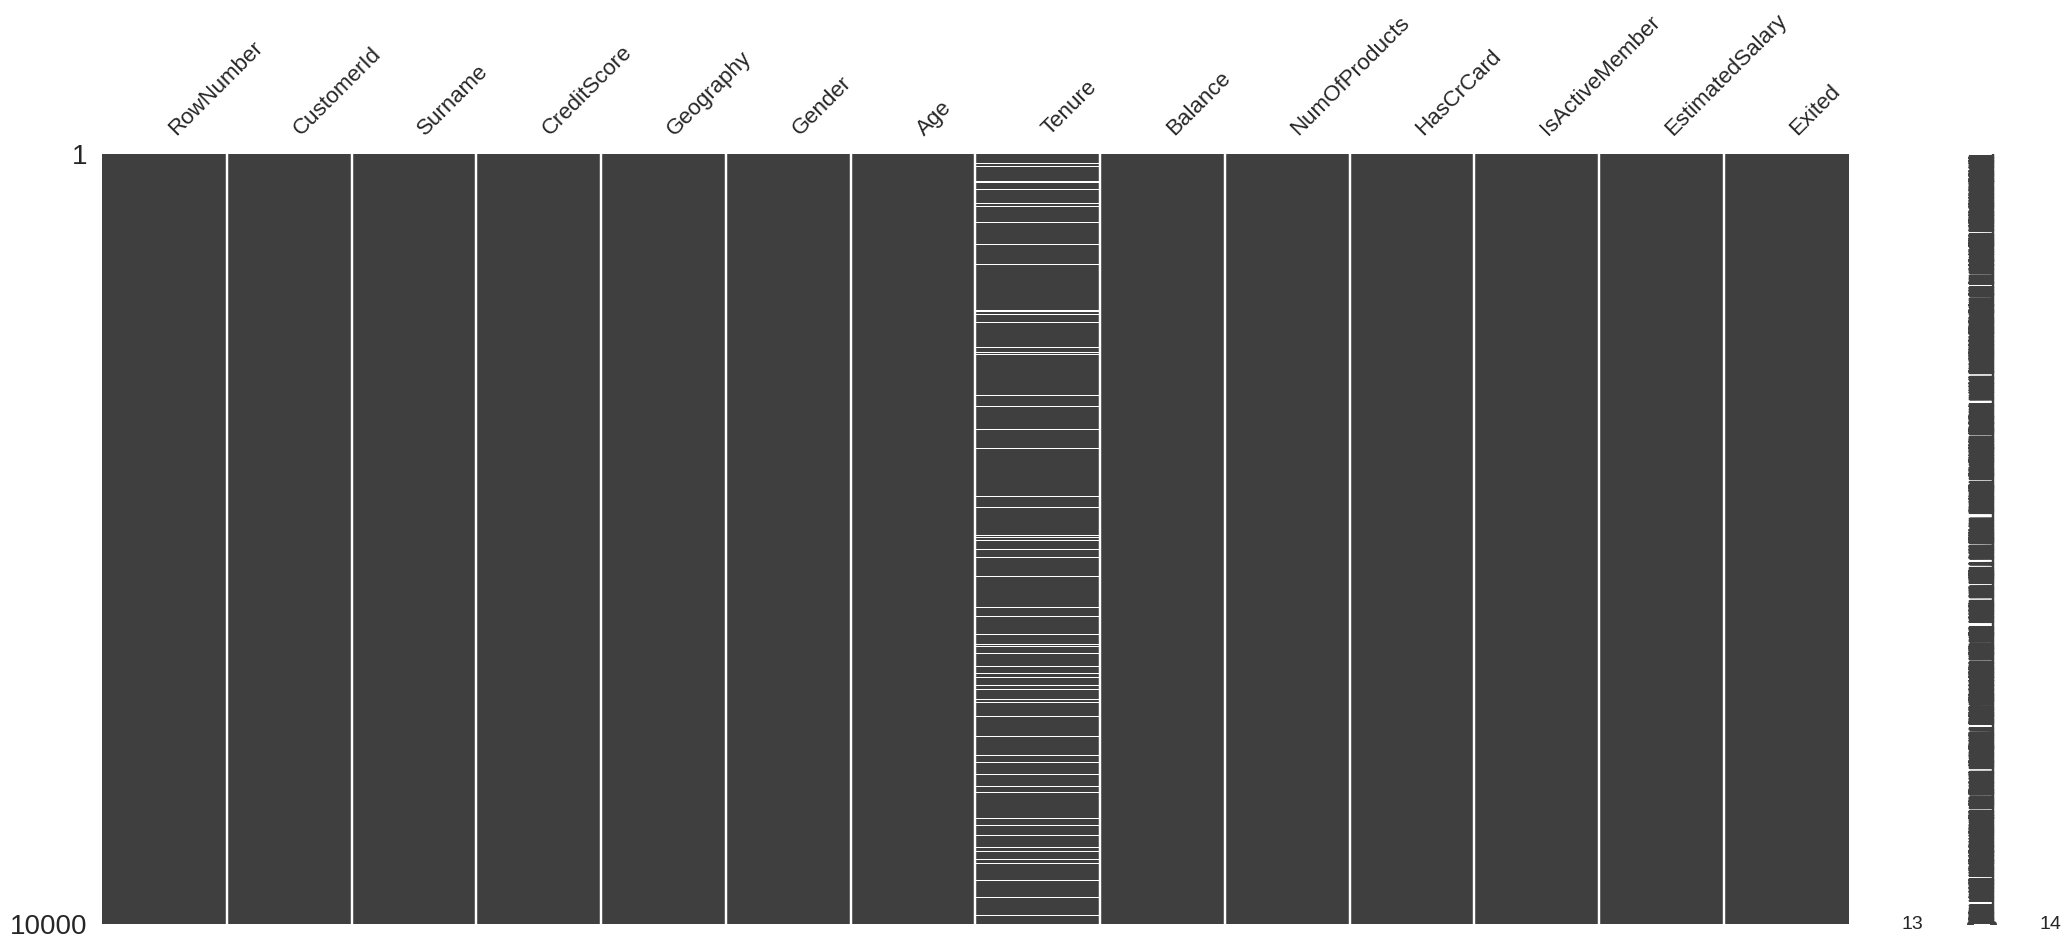

In [6]:
msno.matrix(df)

Посмотрим более внимательно на строки с пропусками 

In [7]:
df[df['Tenure'].isnull()].sample(10)

RowNumber  CustomerId       Surname  CreditScore Geography  Gender  Age  \
8411       8412    15719479  Chukwuhaenye          619     Spain  Female   56   
4634       4635    15583353         Floyd          610     Spain  Female   45   
3971       3972    15790809       Lo Duca          685     Spain    Male   40   
5921       5922    15627203           Hsu          508     Spain    Male   54   
3067       3068    15579781        Buccho          806   Germany    Male   31   
2289       2290    15789097        Keeley          644    France    Male   48   
1682       1683    15662758        Watson          620    France    Male   41   
254         255    15665834      Cheatham          696     Spain    Male   28   
60           61    15651280        Hunter          742   Germany    Male   35   
1124       1125    15627305           Pan          606     Spain    Male   35   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
8411     NaN       0.00              2          1               1   
4634     NaN       0.00              1          1               0   
3971     NaN   74896.92              1          1               0   
5921     NaN       0.00              1          1               1   
3067     NaN  138653.51              1          1               0   
2289     NaN       0.00              2          0               1   
1682     NaN   97925.11              1          1               0   
254      NaN       0.00              1          0               0   
60       NaN  136857.00              1          0               0   
1124     NaN       0.00              1          1               0   

      EstimatedSalary  Exited  
8411         42442.21       0  
4634         38276.84       1  
3971        198694.20       0  
5921        175749.36       0  
3067        190803.37       0  
2289         44965.54       1  
1682         85000.32       0  
254         176713.47       0  
60           84509.57       0  
1124        106837.06       1

Явных паттернов в пропуках нет, из чего делаем вывод, что пропуски имеют случайную природу.

В качестве вариантов выбора стратегий замены пропусков можно рассматривать несколько вариантов:
    - замена средним (на текущих данных критично повлияет на изменение распределения)
    - удаление строк с пропусками (допустимо, т.к. пропусков <10%, но может быть потеряна ценная информация в других признаках)
    - проверить важность признака на этапе моделирования и в случае, если он не критичен, удалить сам признак
    - замена пропусков рандомными значениями (обязательно требуется проверка сохранности распределения признака)

Посмотрим на распределение данных по нашей целевой переменной `Exited`

In [8]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Посмотрим на долевое распределение классов

In [9]:
print('Класс 0 {:.0%}'.format(1-df['Exited'].mean()))
print('Класс 1 {:.0%}'.format(df['Exited'].mean()))

Класс 0 80%
Класс 1 20%


Проверим корреляцию между признаками

<AxesSubplot:>

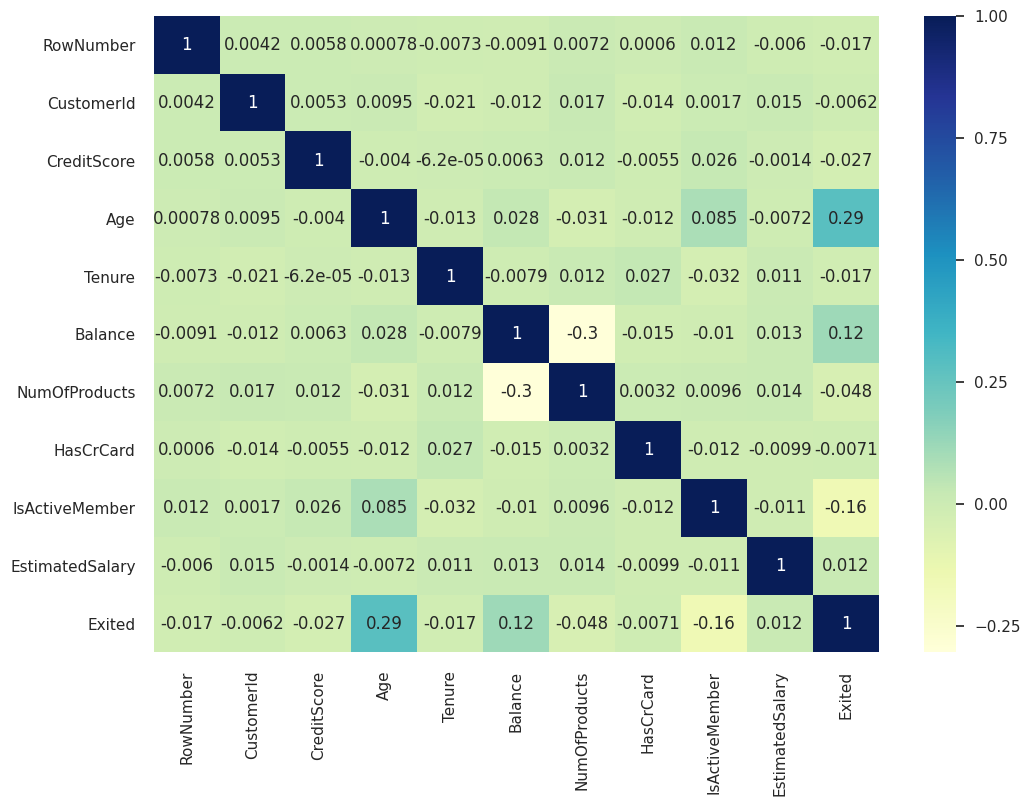

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")

Построим график scatterplot

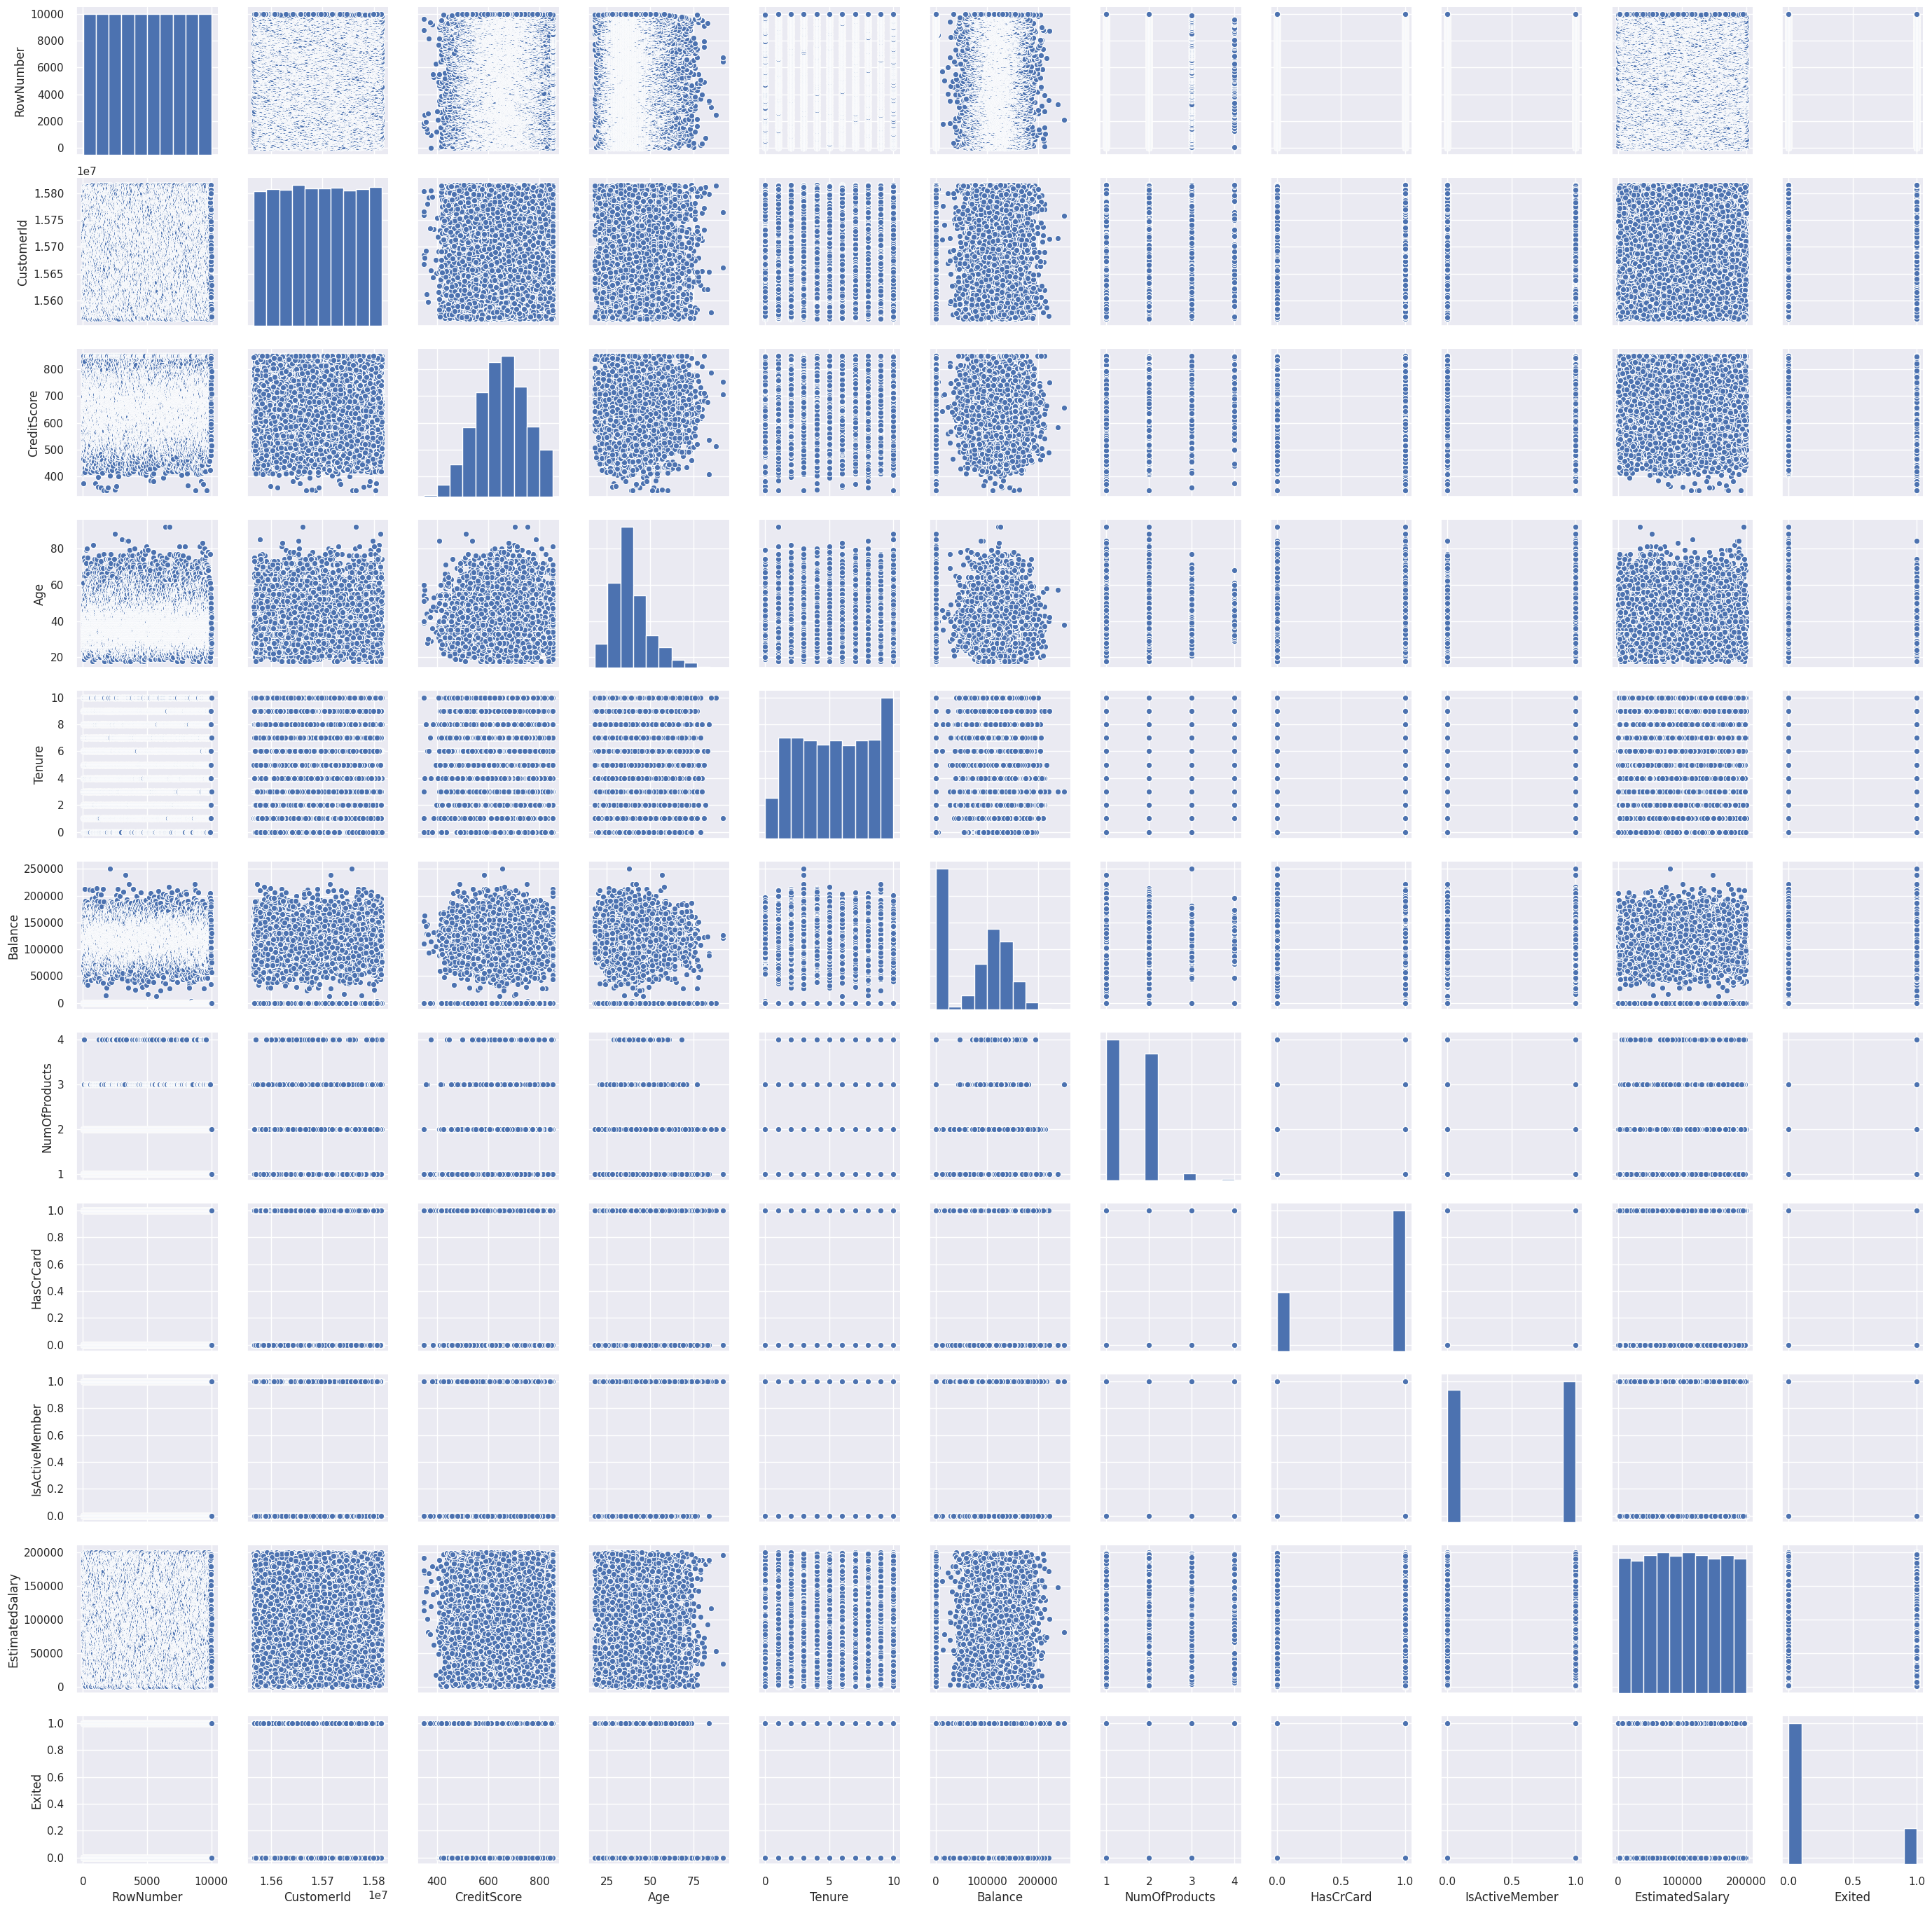

In [11]:
sns.set() 
sns.pairplot(df, size = 2.5)
plt.show();

Корреляционный анализ не выявил признаков, требующих отдельной обработки.

**Вывод**

По итогу анализа предоставленных данных требуется провести следующие преобразования:

- cоздать колонку `Tenure_flag` и проставить в ней флаги для обозначения пропусков (1-пропуск есть, 0-пропуска нет)
- для переменной `Tenure` пропуски заменить Рандомным значением
- удалить колонку `Surname` - не является характеристикой уникальности клиента 
- удалить колонки `CustomerId` и `RowNumber` - дублирует индекс
- преобразовать категориальные признаки `Gender` и `Geography` в числовые с применением техники One-Hot Encoding
- после разбиения датасета на выборки привести признаки `Age`, `Balance`, `Estimatedsalary` и `Balance` к единому масштабу
- поработать с техникой дисбаланса классов

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## Предобработка данных

Создадим признак-индикатор пропусков

In [13]:
miss_ind = MissingIndicator()
miss_ind.fit(df[['Tenure']])
df['Tenure_flag'] = miss_ind.transform(df[['Tenure']])
df['Tenure_flag'] = df['Tenure_flag'].replace(True, 1).astype('int64')

MissingIndicator()

Заменим NAN в признаке `Tenure` рандомными значениями. Первым делом визуализиуем распределение признака до замены

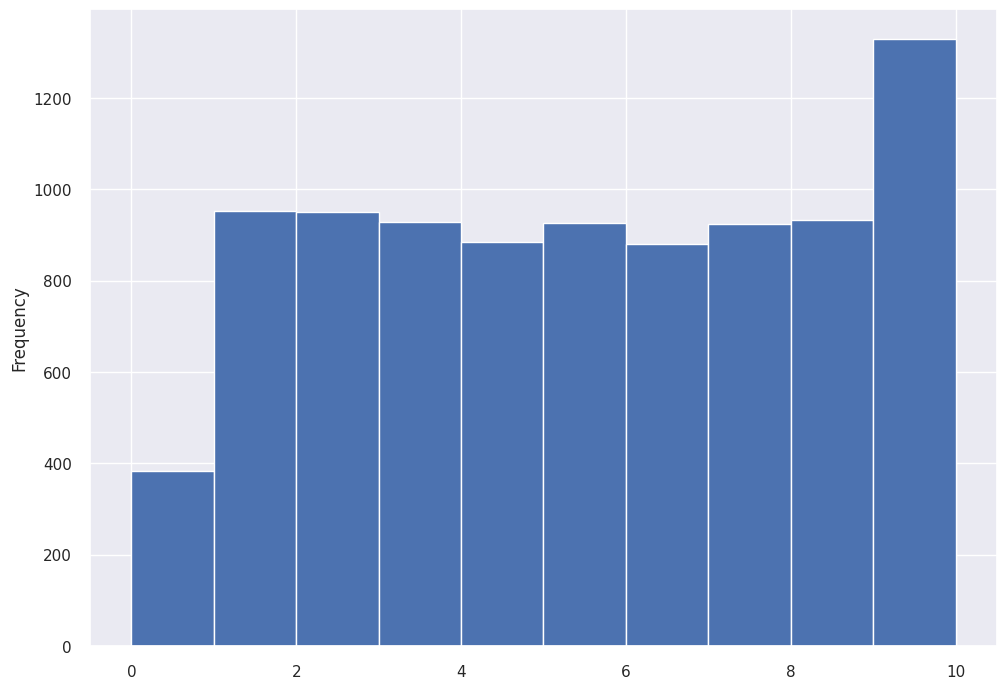

In [14]:
df['Tenure'].plot(kind='hist');

Для замены пропусков будем использовать самописную функцию rand_tenure

In [15]:
df.loc[df['Tenure'].isnull(), 'Tenure'] = df.loc[df['Tenure'].isnull(), 'Tenure'].apply(rand_tenure)
df['Tenure'] = df['Tenure'].astype('int64')

Проверим распределение после замены значений

<AxesSubplot:ylabel='Frequency'>

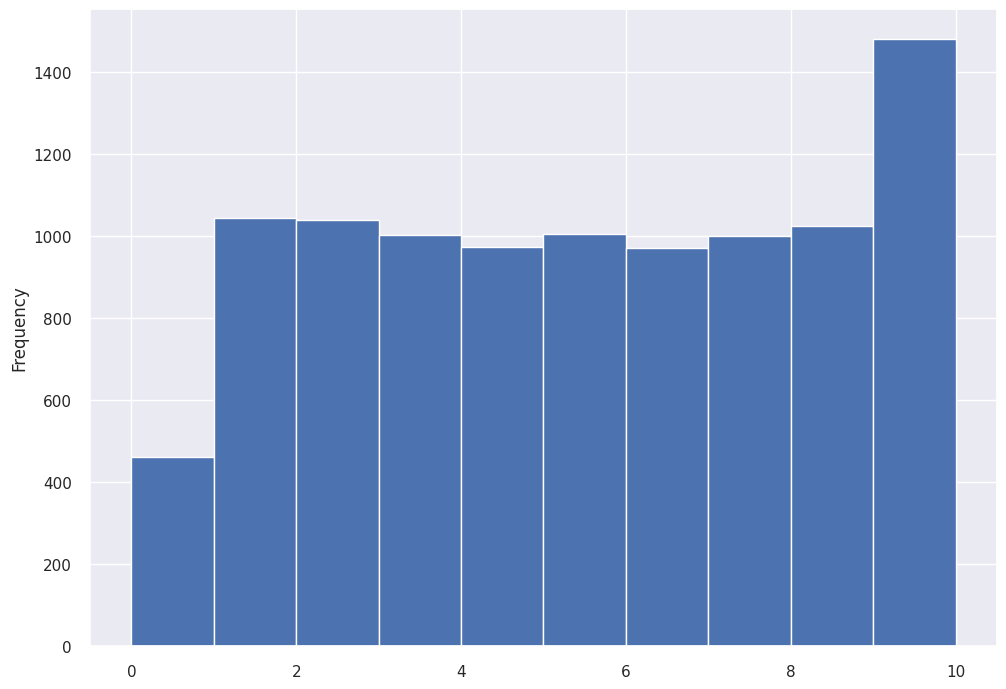

In [16]:
df['Tenure'].plot(kind='hist')

Распределение не изменило свой вид.

Удалим признаки `RowNumber`, `Surname` и `CustomerId`

In [17]:
df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1, inplace=True)

Преобразуем категориальные признаки `Gender` и `Geography` в числовые с помощью OHE

In [18]:
df = pd.get_dummies(df, drop_first=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Tenure_flag          10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(2), int64(8), uint8(3)
memory usage: 810.7 KB


Разделим данные на выборки: обучающую (60%), валидационную (20%) и тестовую (20%). В отдельной переменной сохраним объединенный набор объединяющий обучающую и валидационную выборки для переобучения финальной модели и проверки на отложенной тестовой выборке. Будем использовать паремтр stratify для задания пропорции классов при разделении.

In [20]:
# В переменную features поместим датасет 
# целевой признак поместим в переменную target
features = df.copy()
target = df['Exited']

# Поделим данные на обучающий и тестовый наборы
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.20, random_state=SEED, stratify=target)

# Далее обучающий набор делим на обучающий и валидационный
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.20, random_state=SEED, stratify=target_train_valid)

Посмотрим на размер получившихся наборов данных

In [21]:
frame_dict = {'train_valid': [features_train_valid, target_train_valid], 
              'train': [features_train, target_train],
              'valid': [features_valid, target_valid], 
              'test': [features_test, target_test]}

In [22]:
frame_shape(frame_dict)

Размер выборок train_valid: features (8000, 13), target (8000,)
Размер выборок train: features (6400, 13), target (6400,)
Размер выборок valid: features (1600, 13), target (1600,)
Размер выборок test: features (2000, 13), target (2000,)


Стандартизируем признаки `EstimatedSalary`, `Balance`, `CreditScore`, `Age` методом StandardScaler

In [23]:
numeric = ['EstimatedSalary', 'Balance', 'CreditScore', 'Age']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train_valid[numeric] = scaler.fit_transform(features_train_valid[numeric])

StandardScaler()

Визуализируем соотношение классов целевого признака в получившихся выборках

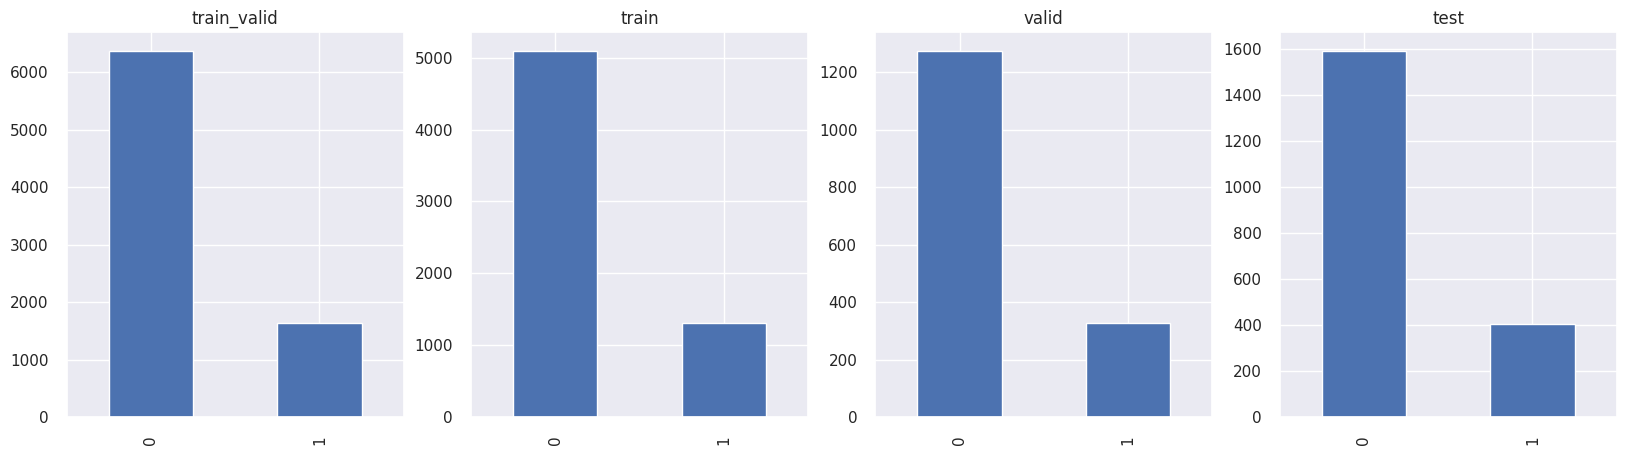

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
ax1, ax2, ax3, ax4 = ax.flatten();
for title, info in {'train_valid': [target_train_valid, ax1], 
                       'train': [target_train, ax2], 
                       'valid': [target_valid, ax3], 
                       'test': [target_test, ax4]}.items():
    balance_viz(info[0], title, info[1])

Запустим инструмент sweetviz для анализа схожести распределения признаков и целевого признака.


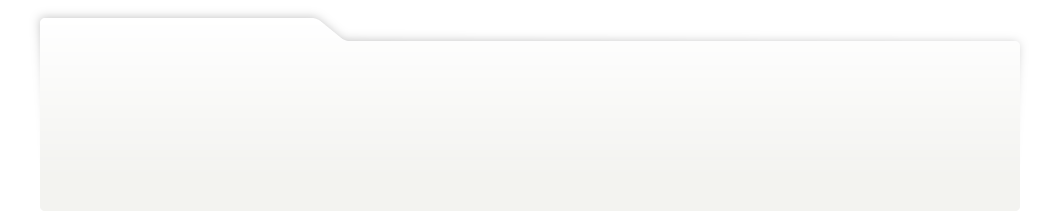
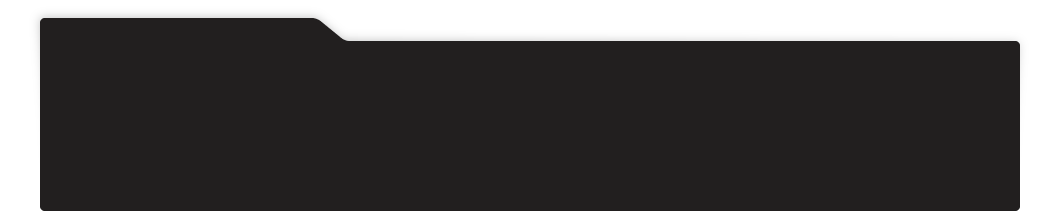
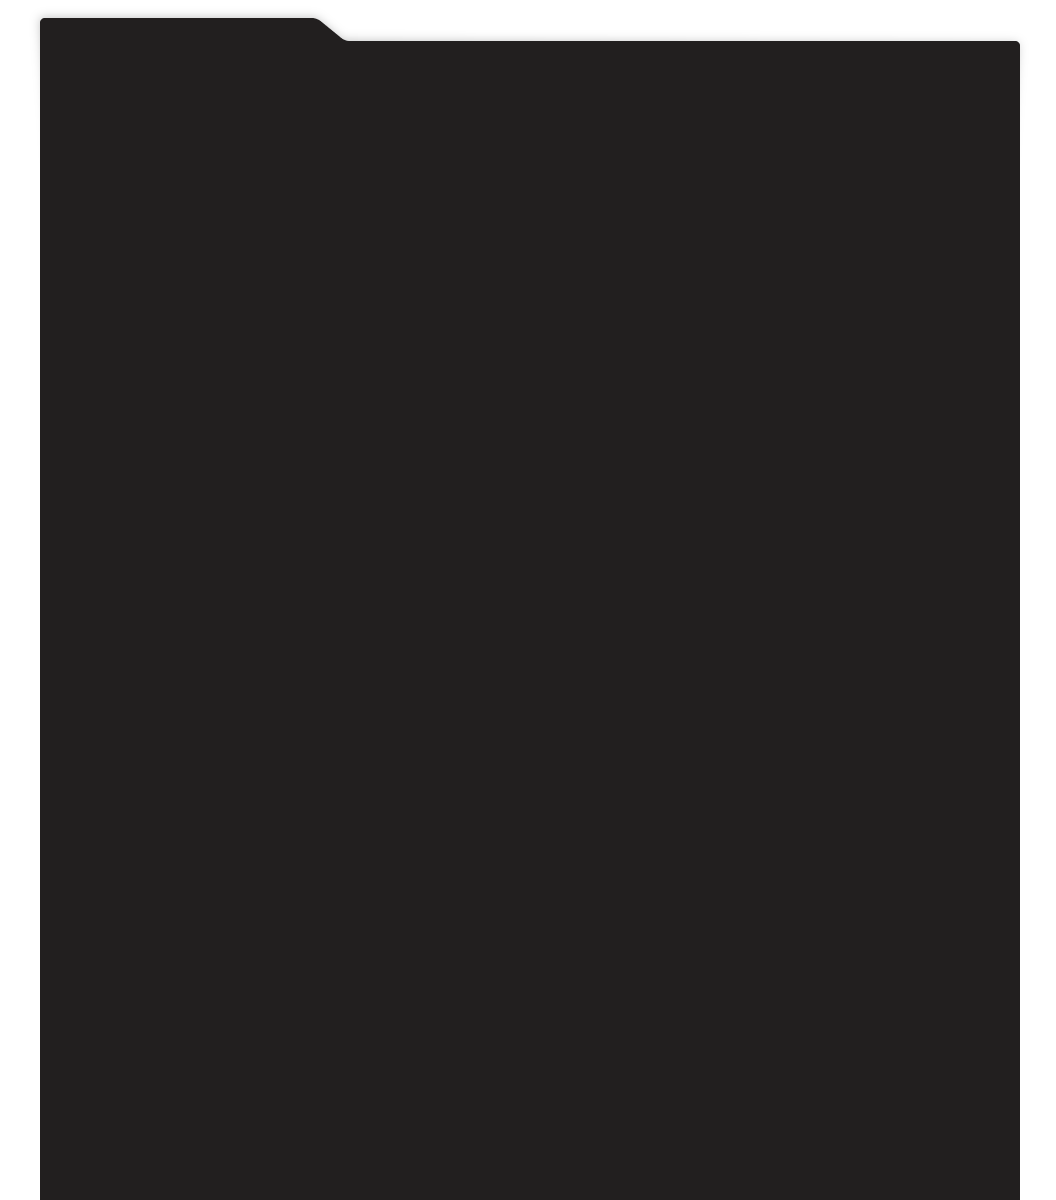
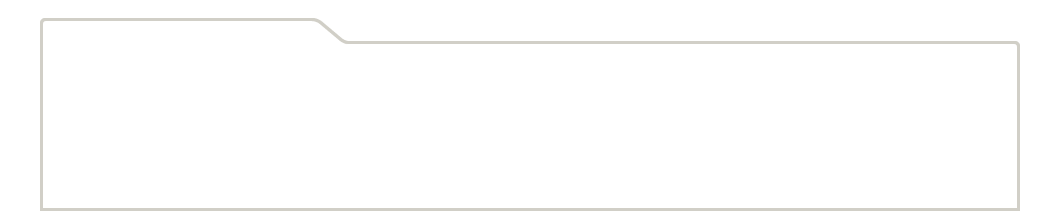
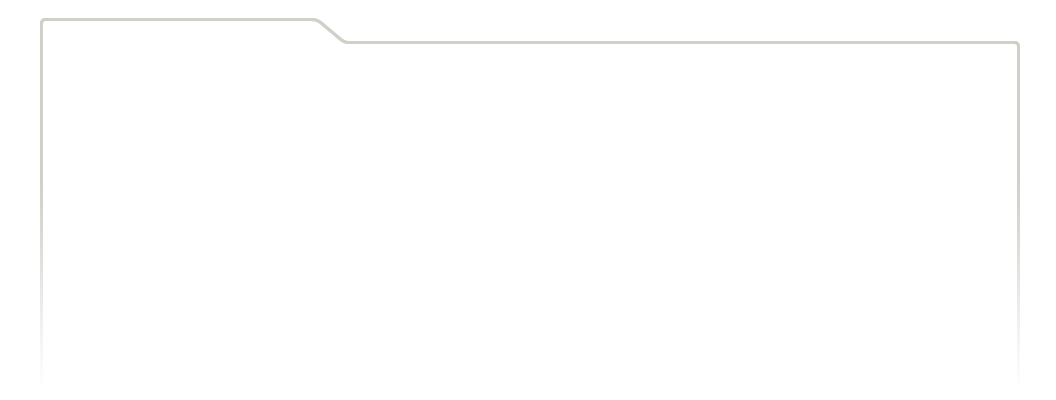
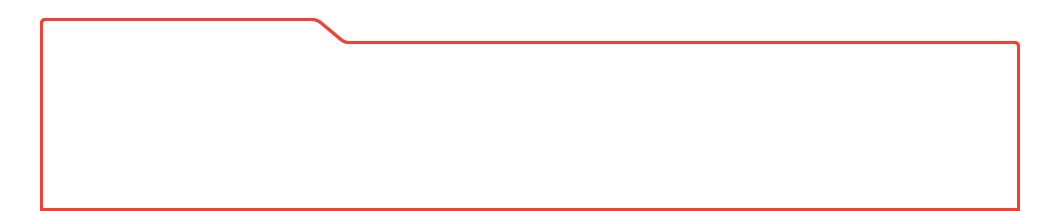
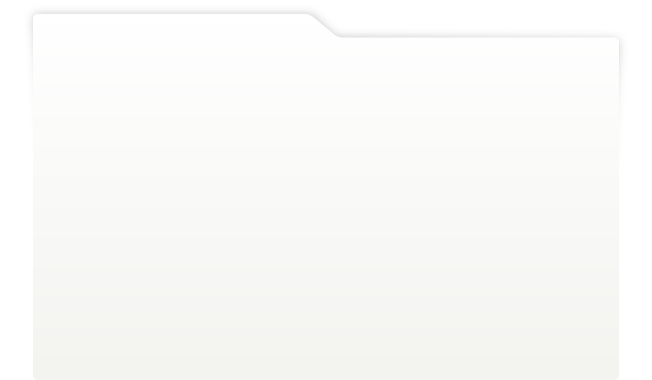
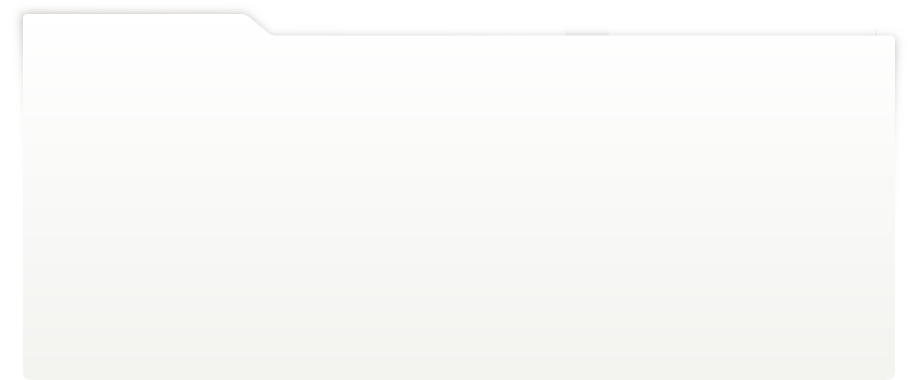
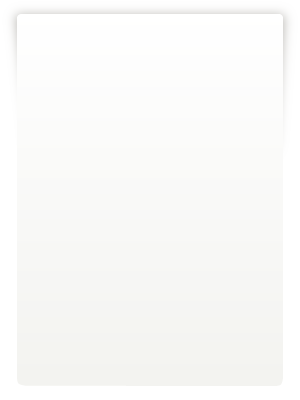
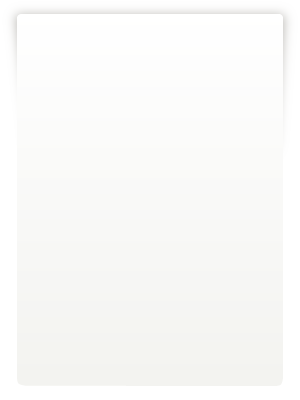
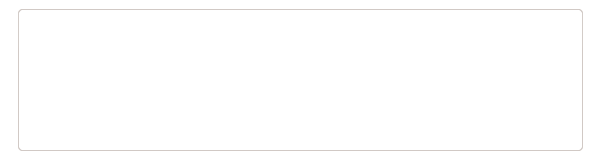
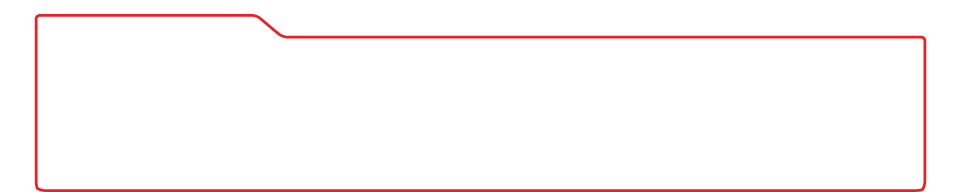
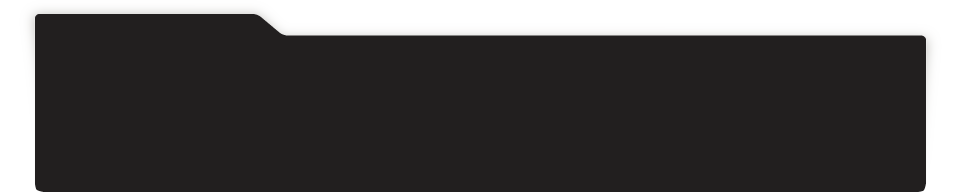
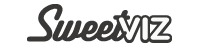
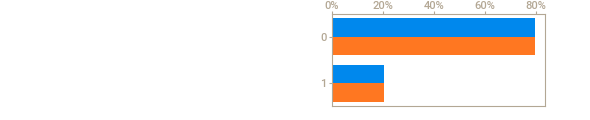
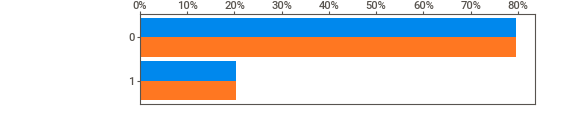
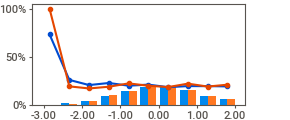
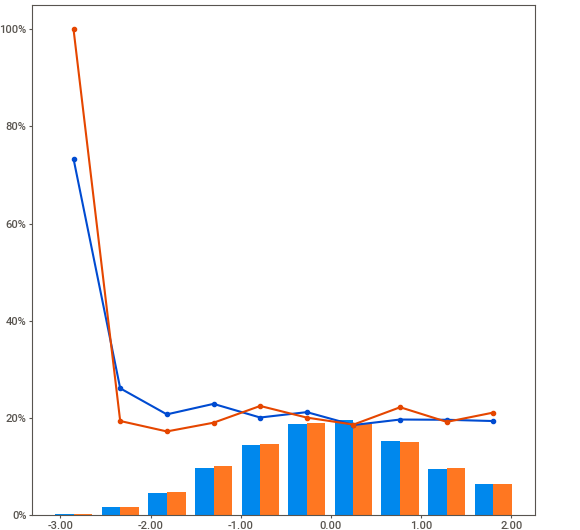
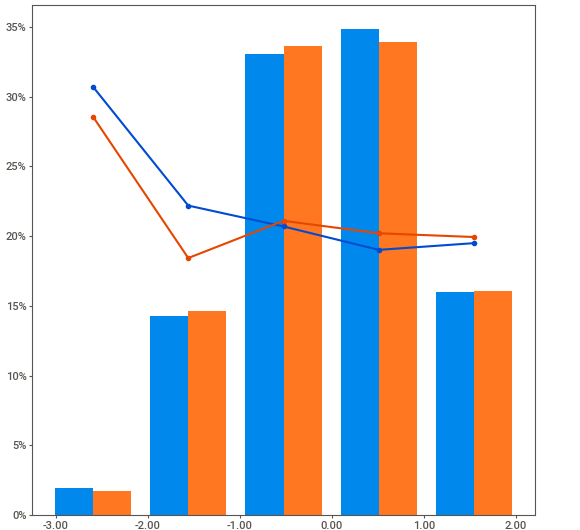
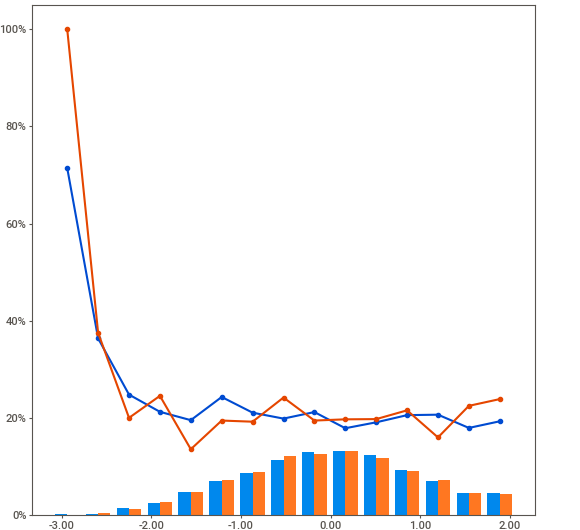
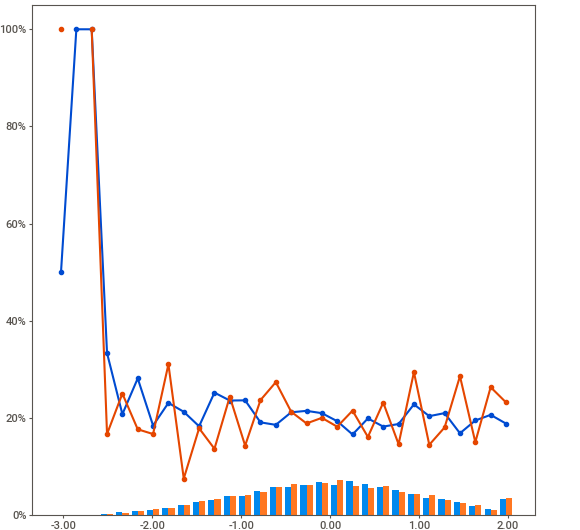
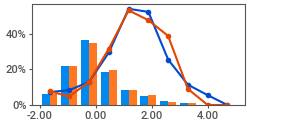
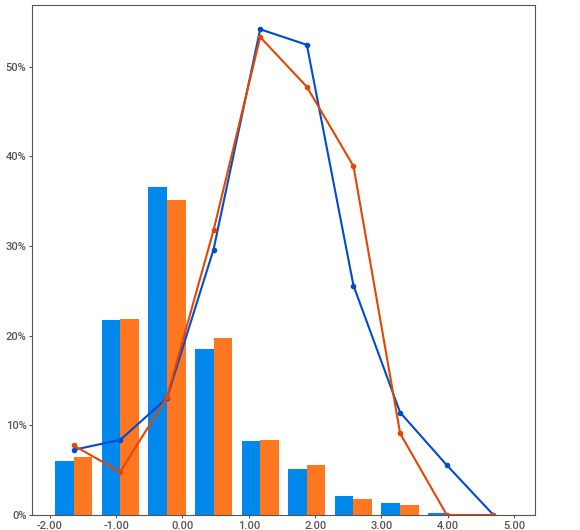
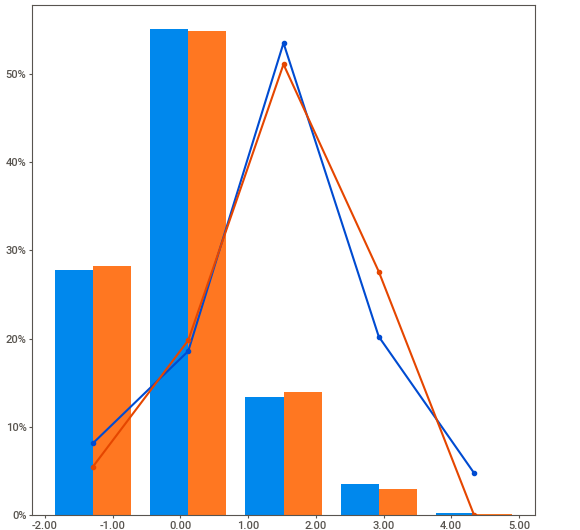
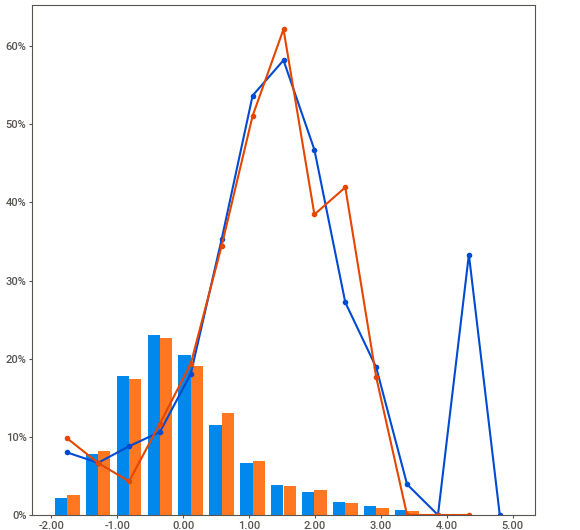
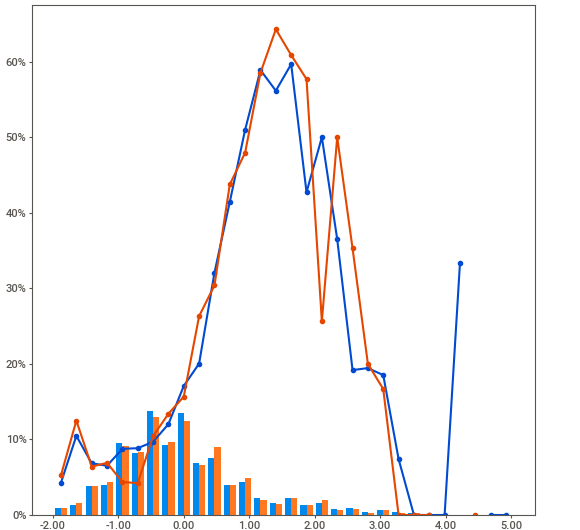
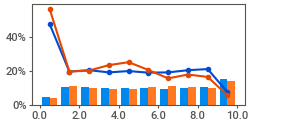
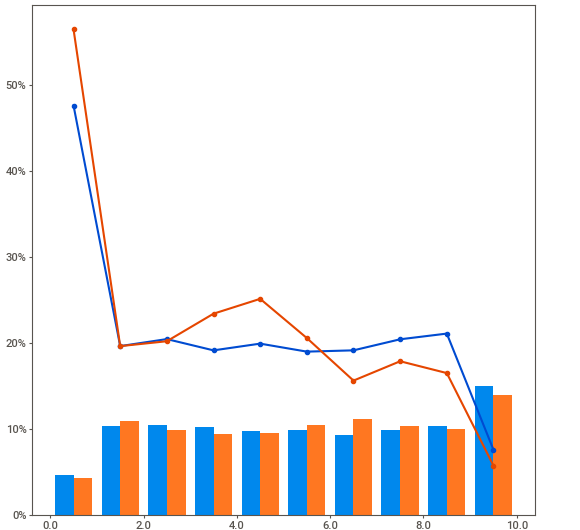
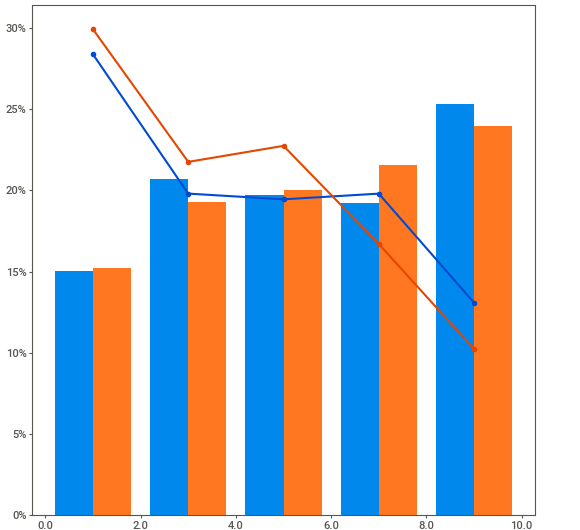
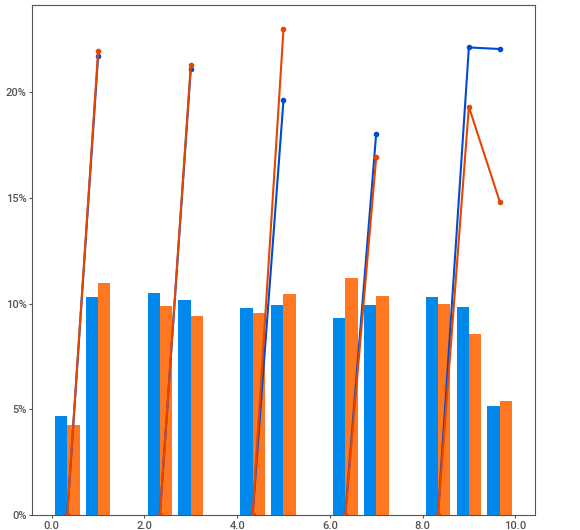
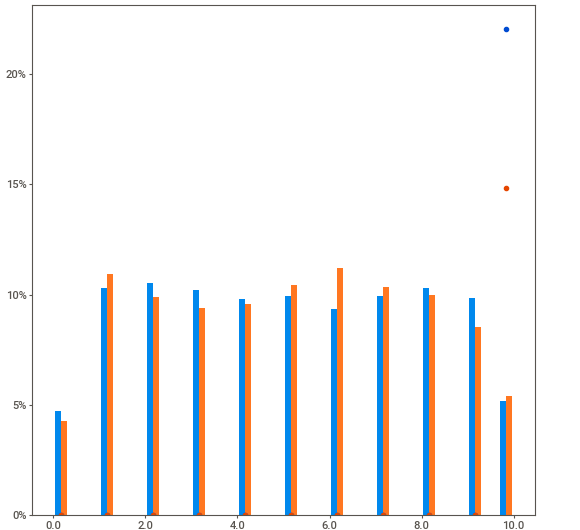
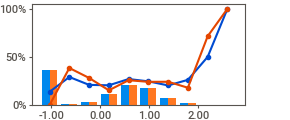
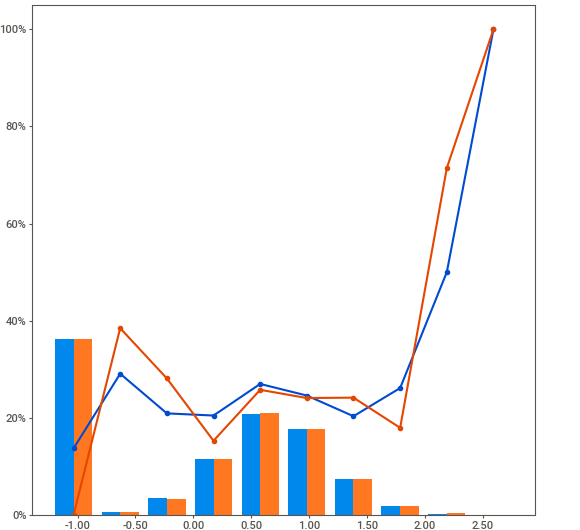
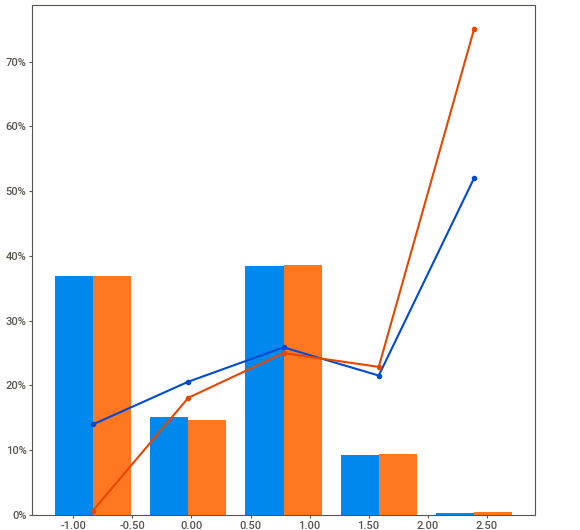
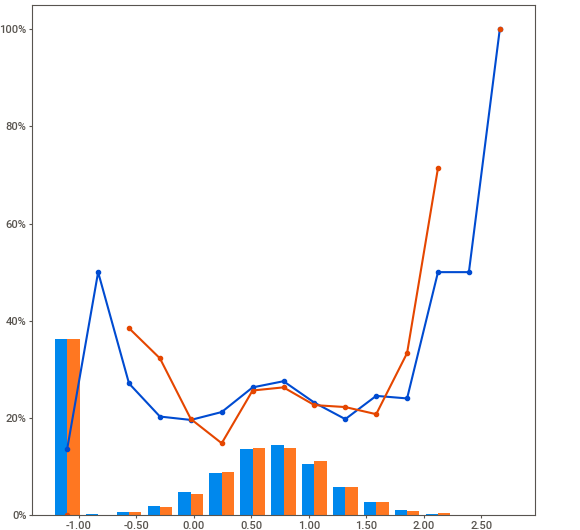
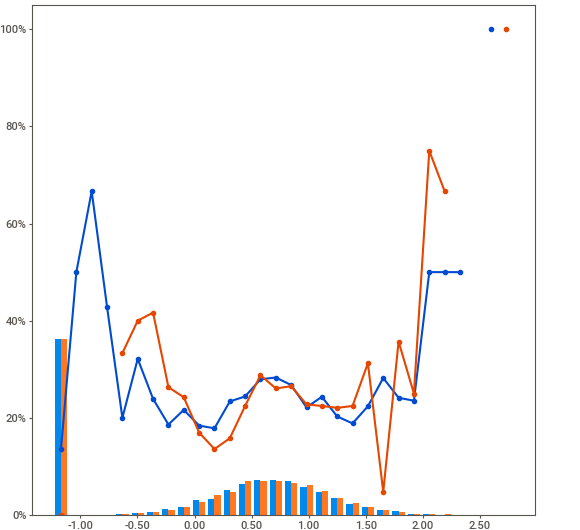
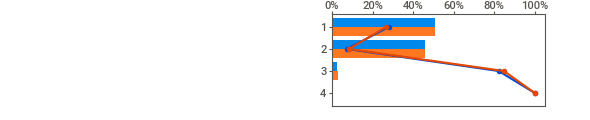
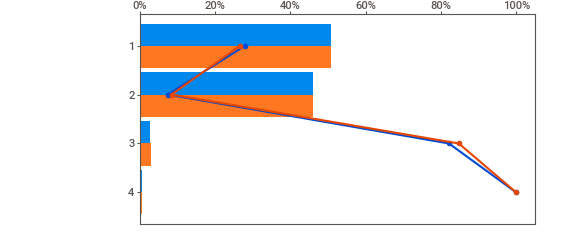
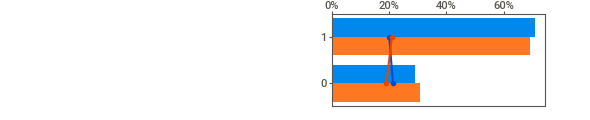
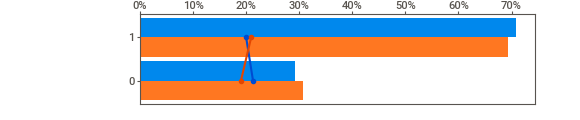
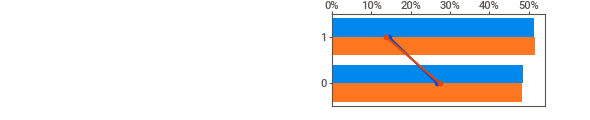
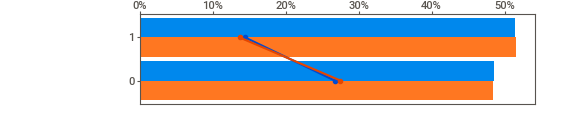
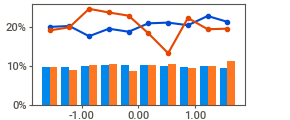
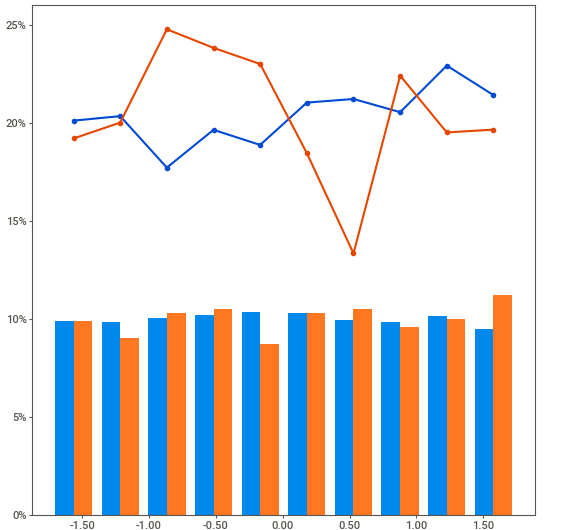
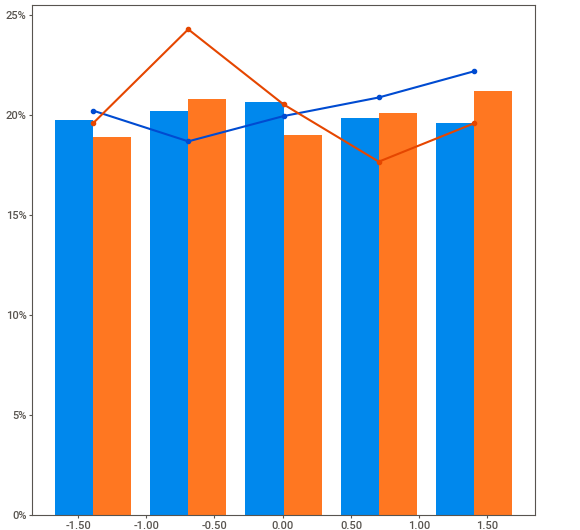
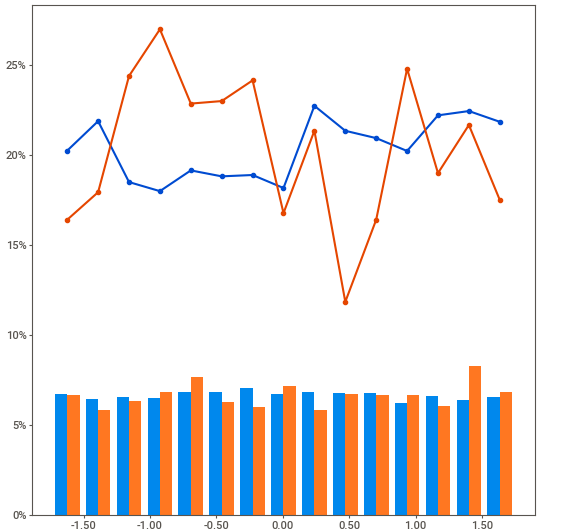
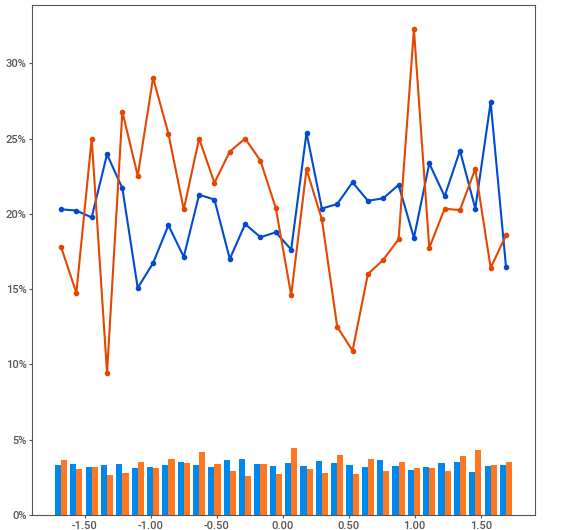
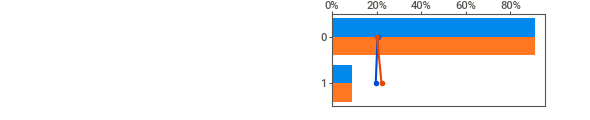
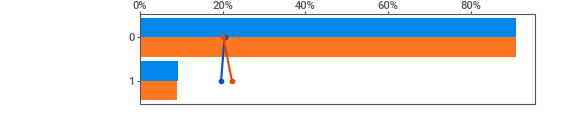
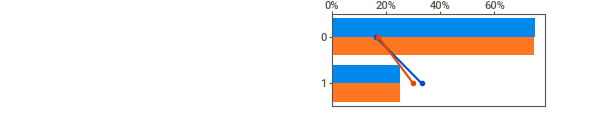
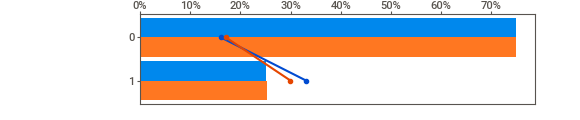
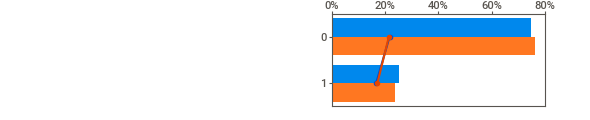
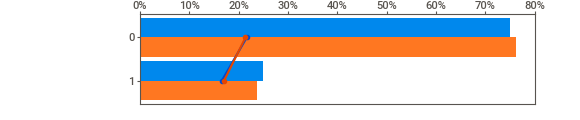
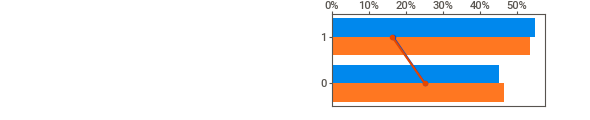
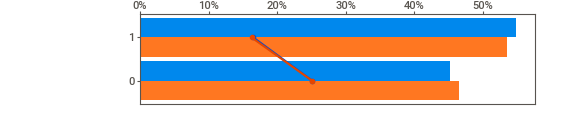
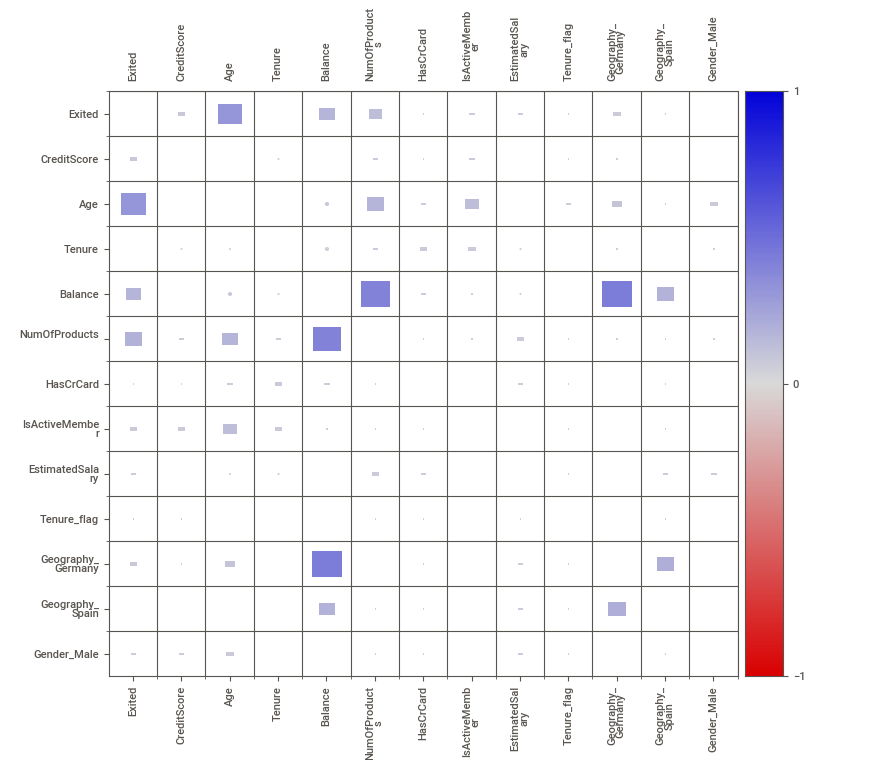
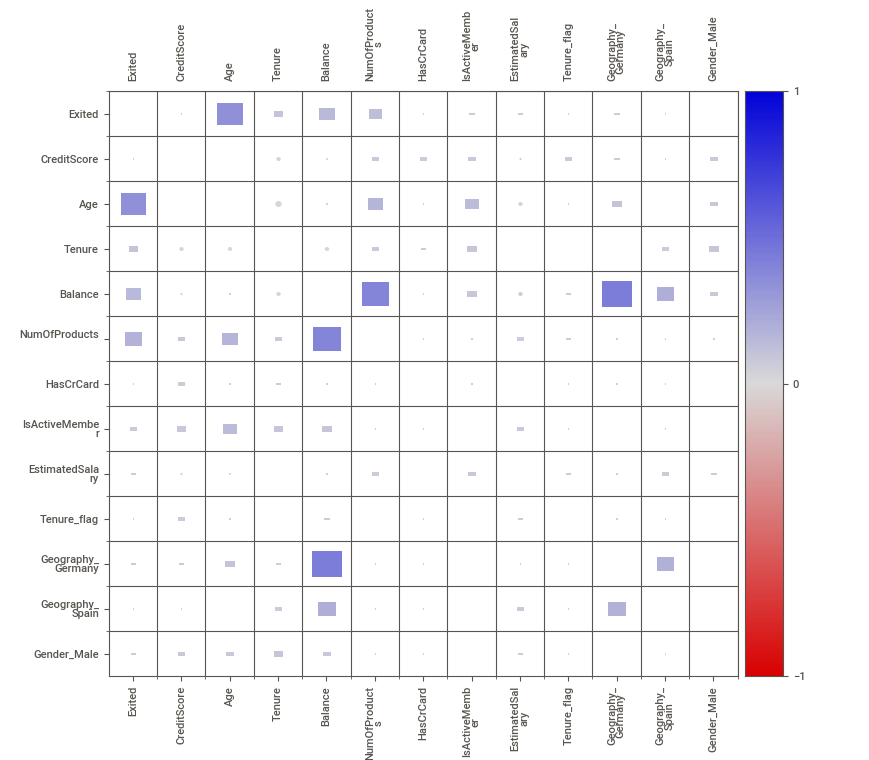

In [25]:
sv_report = sv.compare([features_train_valid, "Train_valid"], [features_test, "Test"], target_feat='Exited')
sv_report.show_notebook()

Деление на выборки произведено корректно, балансировка и распределние целевого класса сохранены. 

Удалим целевой признак из выборок features

In [26]:
features_train_valid = features_train_valid.drop(['Exited'], axis=1)
features_train = features_train.drop(['Exited'], axis=1)
features_valid = features_valid.drop(['Exited'], axis=1)
features_test = features_test.drop(['Exited'], axis=1)

frame_shape(frame_dict)

Размер выборок train_valid: features (8000, 13), target (8000,)
Размер выборок train: features (6400, 13), target (6400,)
Размер выборок valid: features (1600, 13), target (1600,)
Размер выборок test: features (2000, 13), target (2000,)


**Вывод**

- для переменной `Tenure` создали индикатор пропусков, заменили пропуски медианой и изменили тип данных на int 
- преобразовали категориальные признаки в числовые
- удалили дублирующие признаки `RowNumber`, `Surname` и `CustomerId`
- произведено разделение данных на обучающую, валидационную и тестовую выборки
- подготовлен объединенный набор обучающая + валидационная 
- произведено масштабирование признаков `EstimatedSalary`, `Balance`, `CreditScore`, `Age` 

В рамках исследования выявлен факт сильного дисбаланса выборки - значений одного из прогнозируемых классов значительно больше. Данный факт может отрицательно сказаться на результат использования. В ходе дальнейшего решения сначала запустим модели на несбалансированном датасете, выберем лучшую модель, а потом произведем балансировку классов и проверим как это отобразится на качестве модели.

## Моделирование на несбалансированных данных

В процессе моделирования апробируем следующие модели: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier, GradientBoostingClassifier

Сформируем пайплайн

In [27]:
pipe = Pipeline([
    ('model', LogisticRegression(random_state=SEED))
])

params = [{
        'model': [LogisticRegression(random_state=SEED, solver='liblinear')],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.001, 1, 100],
        'model__class_weight' : [None, 'balanced']
     }, {
         'model': [DecisionTreeClassifier(random_state=SEED)],
         'model__max_depth': list(range(5, 16, 5)),
         'model__max_features': range(1, 4),
         'model__min_samples_leaf':range(5, 16, 5),
         'model__class_weight' : [None, 'balanced']
     }, {
         'model': [RandomForestClassifier(random_state=SEED)],
         'model__n_estimators': list(range(10, 201, 10)),
         'model__max_depth': list(range(5, 16)),
         'model__class_weight' : [None, 'balanced']
     }, {
         'model': [CatBoostClassifier(random_state=SEED, logging_level='Silent')]
     }, {
         'model': [GradientBoostingClassifier(random_state=SEED)]
}
]

Запустим алгоритм RandomizedSearchCV - случайный поиск гиперпараметров из сетки

In [28]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
rs = RandomizedSearchCV(pipe, params, scoring='f1', cv=kf, verbose=False, return_train_score=True, n_iter=200, random_state=SEED)
rs = rs.fit(features_train, target_train)

Сгруппируем результаты RandomizedSearchCV в таблицу

In [29]:
rs_results = pd.DataFrame(rs.cv_results_)
models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier', 'GradientBoostingClassifier']
cols = ['mean_fit_time', 'mean_score_time', 'mean_train_score', 'mean_test_score']
res = pd.DataFrame(columns=cols)

for model in models:
    model_idx = rs_results['param_model'].astype('str').str.contains(model)
    best_fit = rs_results[model_idx].sort_values(by='rank_test_score').head(1)[cols]
    res = res.append(round(best_fit, 3))
    res.loc[best_fit.index, 'model'] = model

res.sort_values(by='mean_test_score', ascending=True)

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
163          0.084            0.011            0.497             0.500   
19           0.035            0.005            0.539             0.632   
37          23.167            0.010            0.572             0.818   
186          0.516            0.038            0.615             0.774   

                      model  
163      LogisticRegression  
19   DecisionTreeClassifier  
37       CatBoostClassifier  
186  RandomForestClassifier

Расчитаем и визуализируем показатели метрик для модели RandomForestClassifier (продемонстрировавшей лучшие результаты) на валидационном наборе данных

ROC-AUC 0.857

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1274
           1       0.58      0.64      0.61       326

    accuracy                           0.83      1600
   macro avg       0.74      0.76      0.75      1600
weighted avg       0.84      0.83      0.83      1600



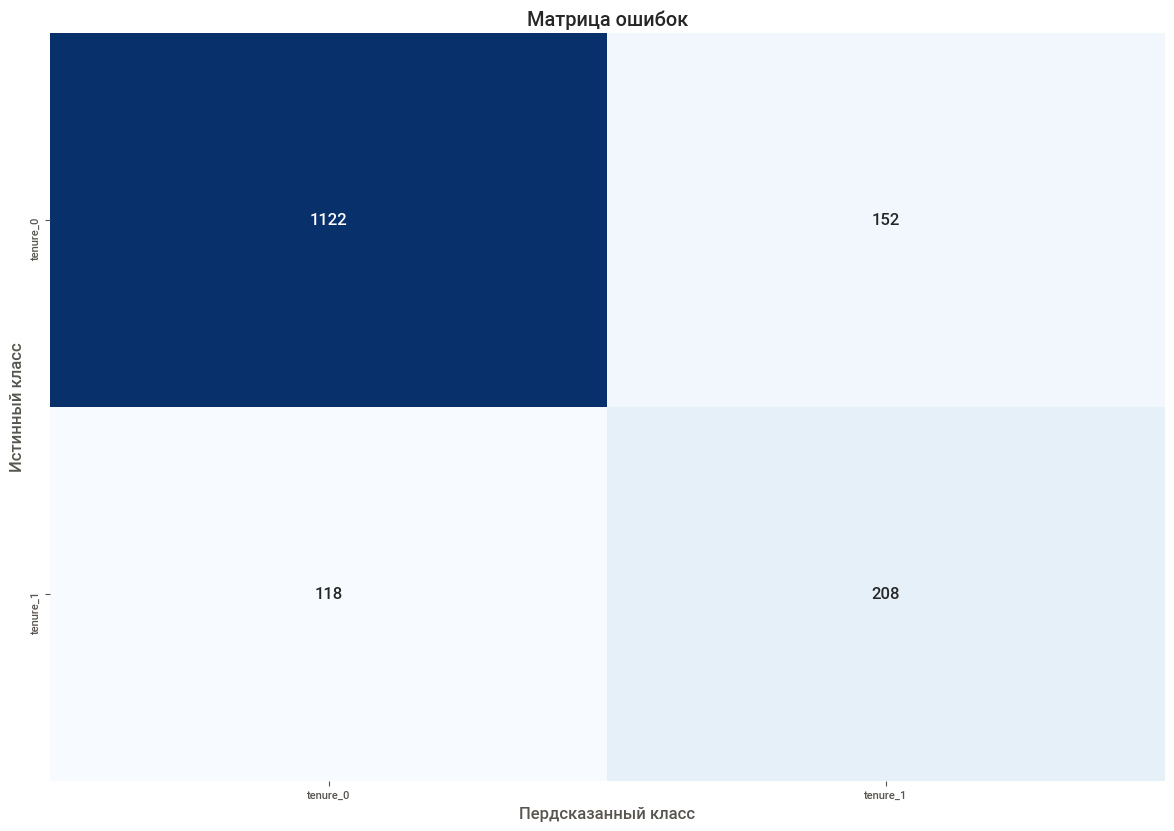

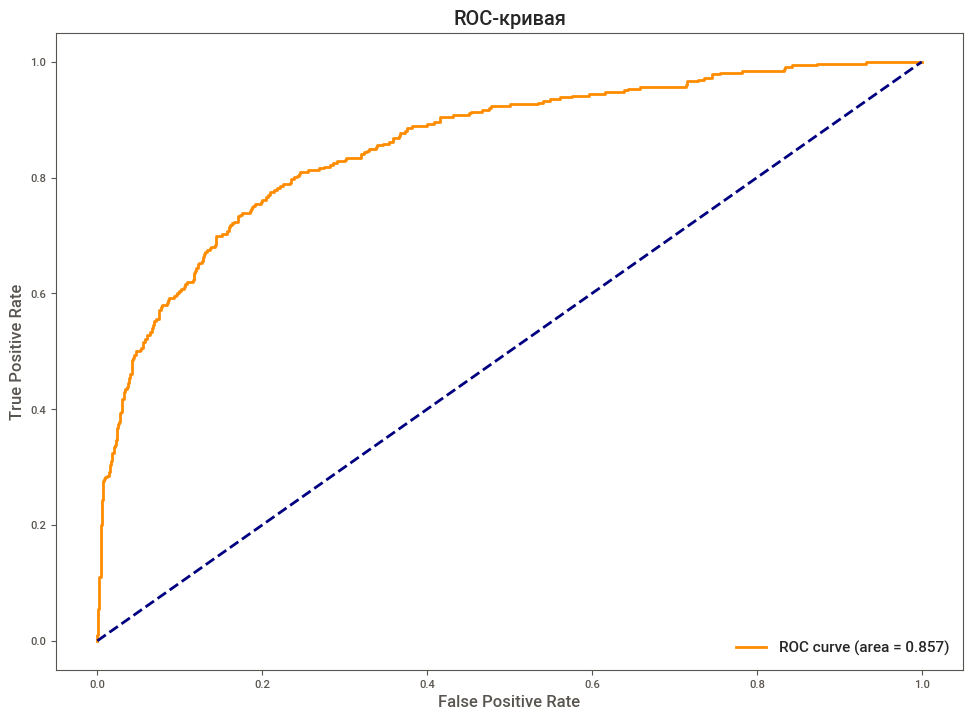

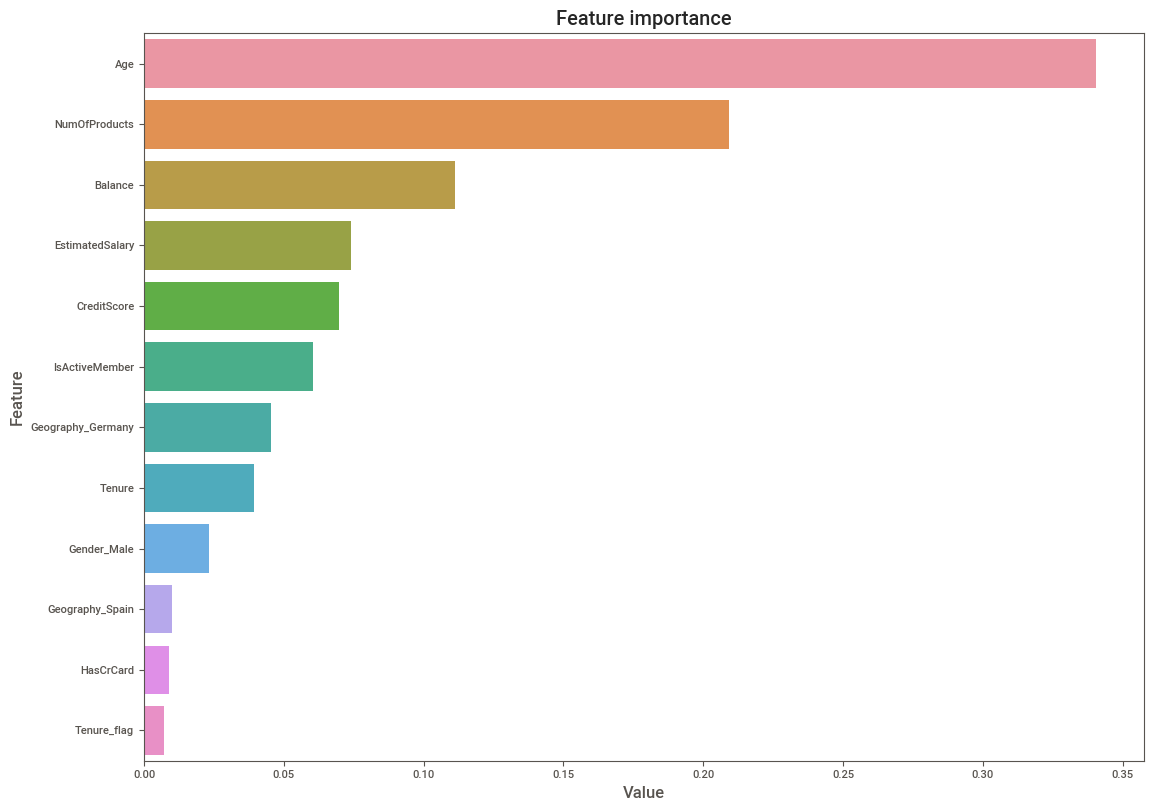

In [30]:
final_estimator = rs.best_estimator_._final_estimator
res_disbalance = metric_info(features_valid, target_valid, final_estimator)

**Вывод**

Проведено моделирование с использованием следующих алгоритмов:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier 
- CatBoostClassifier 
- GradientBoostingClassifier

Лучшие показатели продемонстрировала модель RandomForestClassifier 

Модель продемонстрировала хорошее значение метрик ROC-AUC и F1-score (для отрицательных случаев, когда клиент остается с банком), но при этом демонстрирует плохую прогнозную способность по определению интересующих бизнес положительных случаев (когда клиент уходит) - низкие значения метрик F1-score и recall. Предположительно причиной такого поведения являтся критичный дисбаланс классов.

## Борьба с дисбалансом

- применим к данным методику downsampling - уменьшение количества значений мажоритарного класса
- проверим: 
    - размеры выборок 
    - распределения одного из признаков до методики и после (на примере признака `CreditScore`)
    - распределение целевого класса

Размер выборок train_downsampled: features (2833, 12), target (2833, 1)


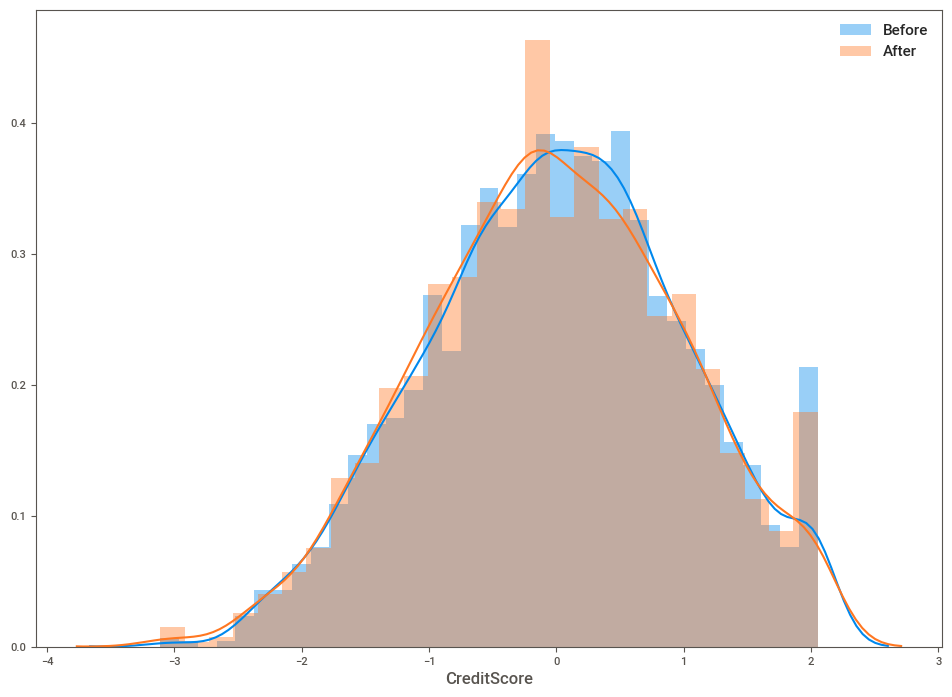

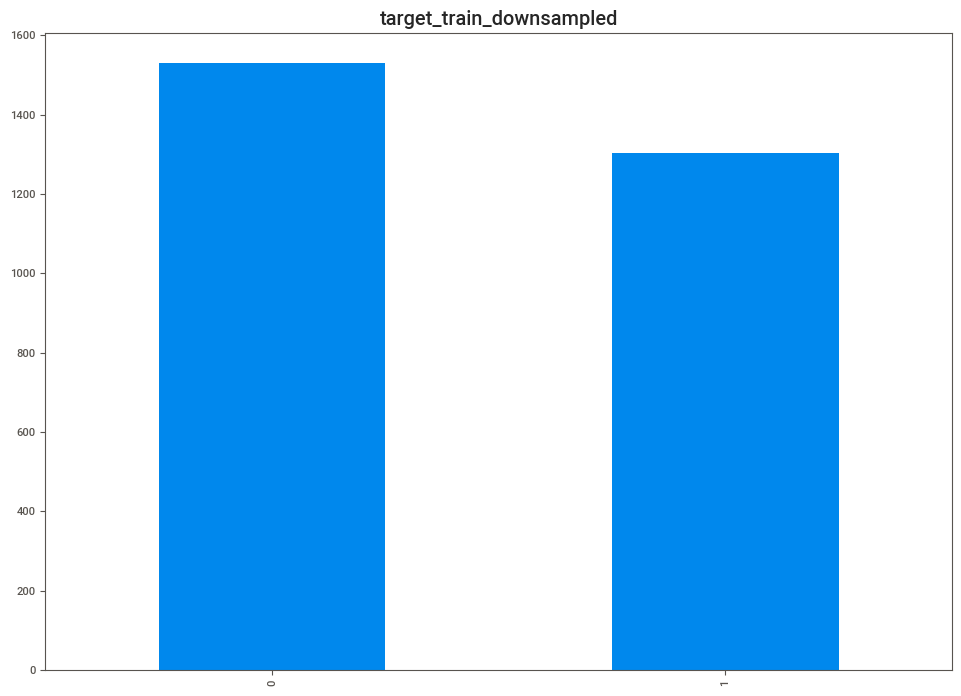

In [31]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.3)

frame_shape({'train_downsampled': [features_train_downsampled, target_train_downsampled]})

distribution_viz(features_train_downsampled)
balance_viz(target_train_downsampled['Exited'], 'target_train_downsampled')

Расчитаем и визуализируем показатели метрик

ROC-AUC 0.856

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1274
           1       0.49      0.76      0.59       326

    accuracy                           0.79      1600
   macro avg       0.71      0.78      0.72      1600
weighted avg       0.84      0.79      0.80      1600



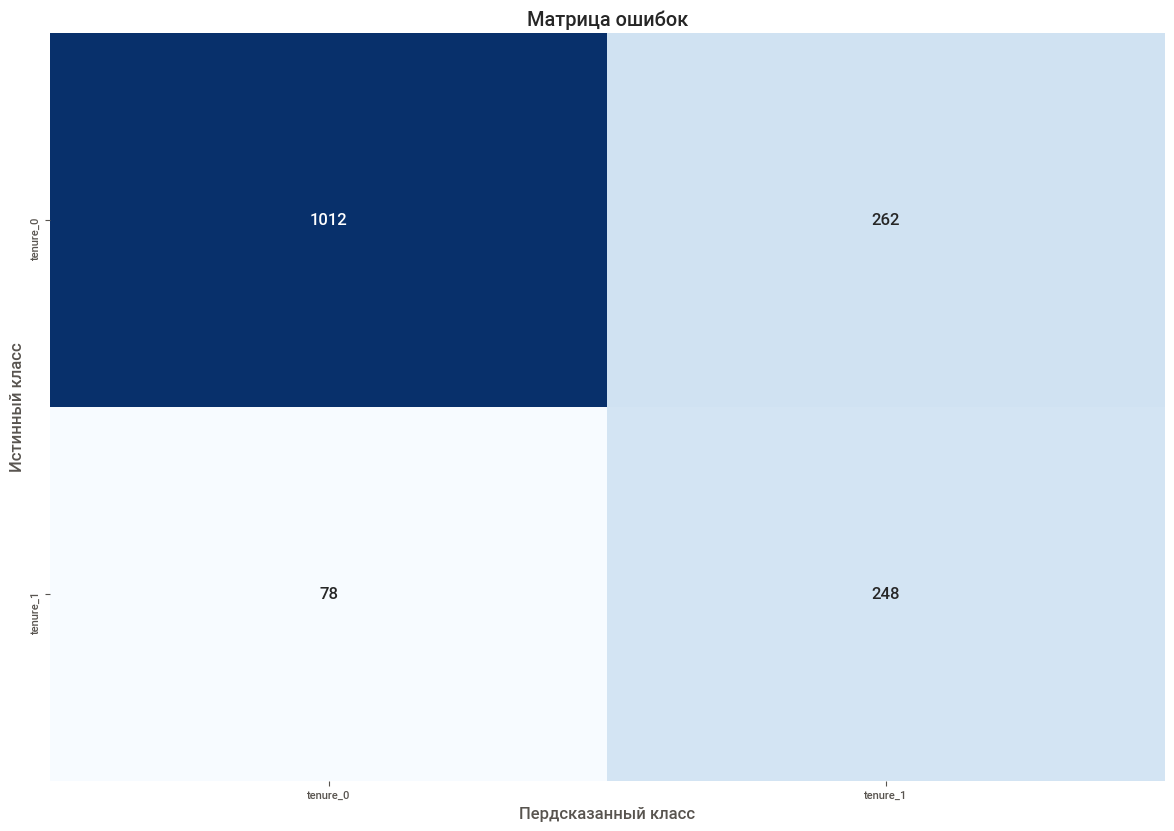

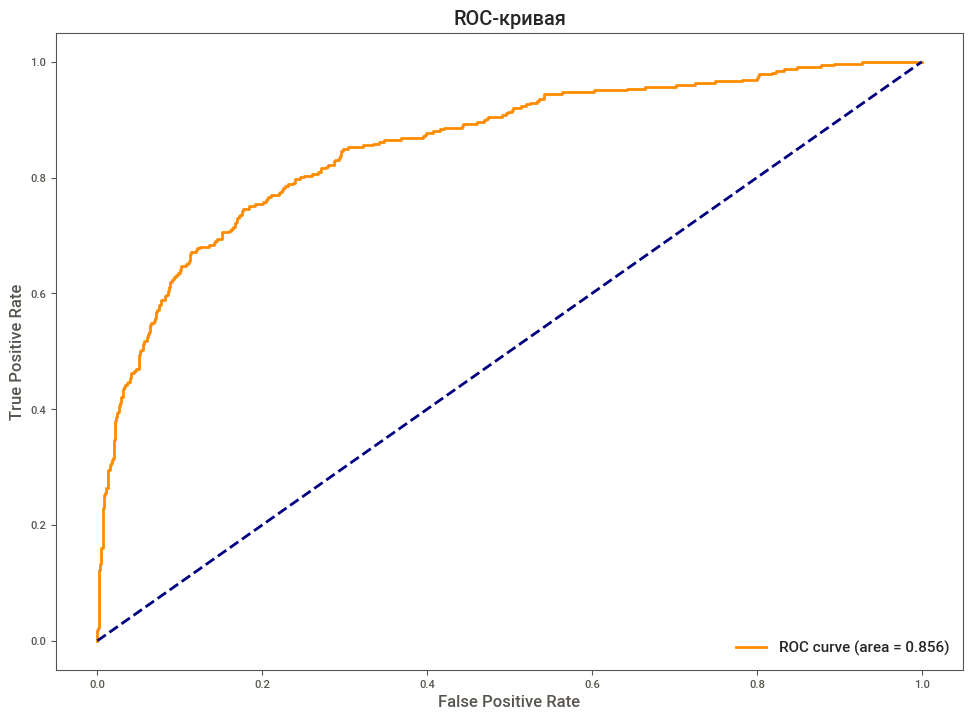

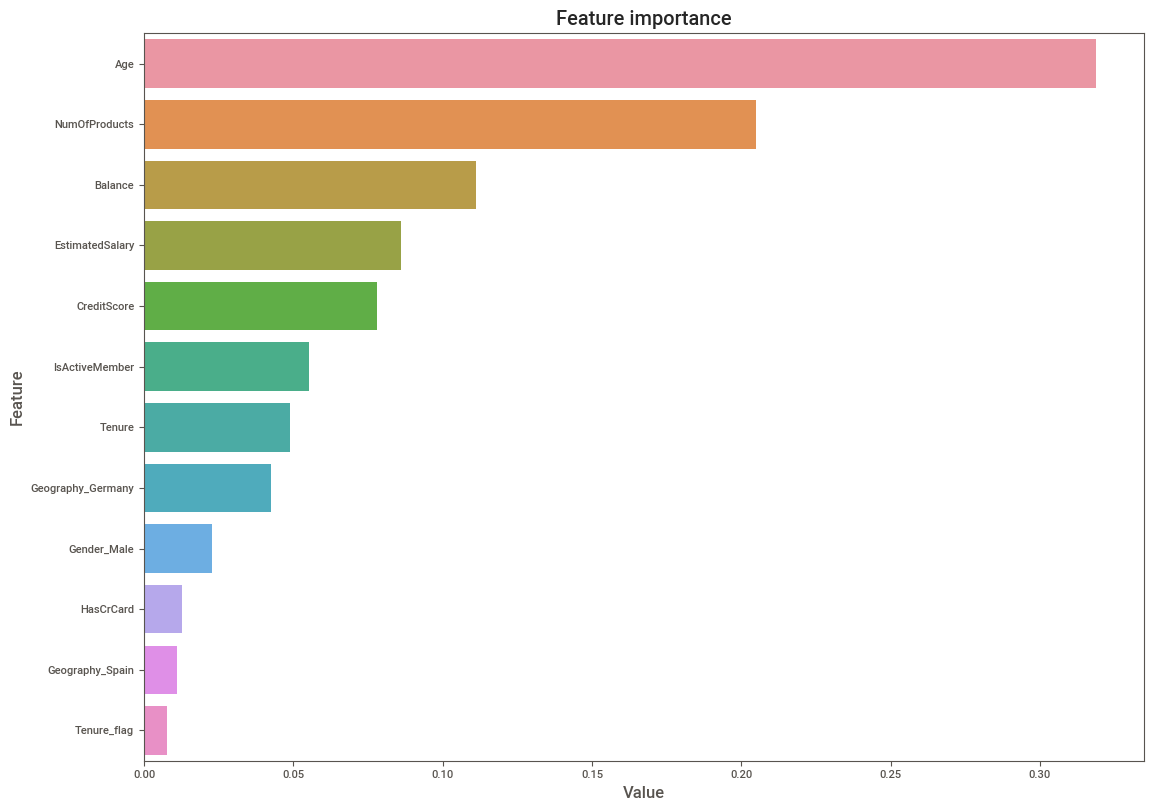

In [32]:
model_down = rs.best_estimator_.fit(features_train_downsampled, target_train_downsampled)
res_down = metric_info(features_valid, target_valid, model_down[0])

Использование методики downsampling привело к увеличению значения метрики recall для положительного класса, но при этом понизилось значение метрики precision, как результат, значение метрики F1-score для положительного класса по-прежнему низкое. Попробуем применить методику upsampling.

- применим к данным методику upsampling - увеличение значений миноритарного класса
- проверим: 
    - размеры выборок 
    - распределения одного из признаков до методики и после (на примере признака `CreditScore`)
    - распределение целевого класса

Размер выборок train_upsampled: features (10312, 12), target (10312,)


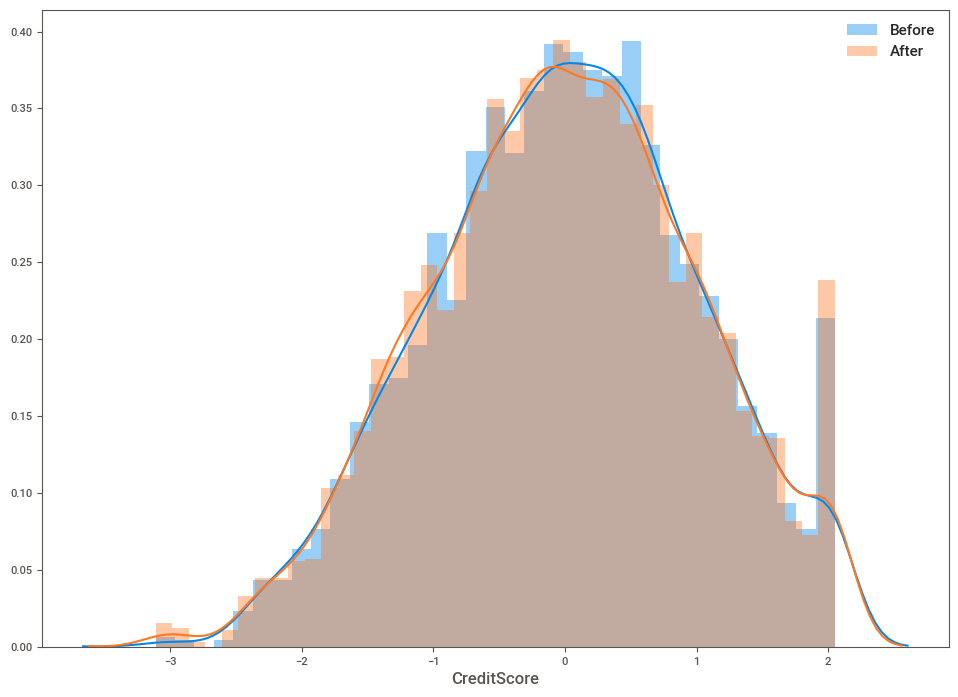

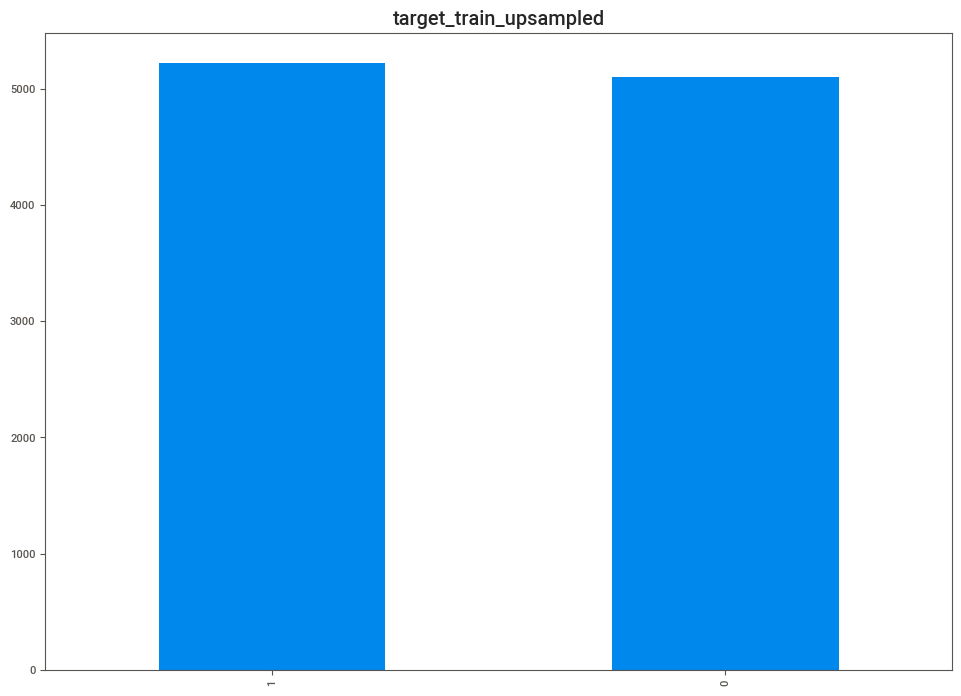

In [33]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

frame_shape({'train_upsampled': [features_train_upsampled, target_train_upsampled]})

distribution_viz(features_train_upsampled)

balance_viz(target_train_upsampled, 'target_train_upsampled')

Расчитаем и визуализируем показатели метрик

ROC-AUC 0.861

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1274
           1       0.56      0.72      0.63       326

    accuracy                           0.83      1600
   macro avg       0.74      0.79      0.76      1600
weighted avg       0.85      0.83      0.84      1600



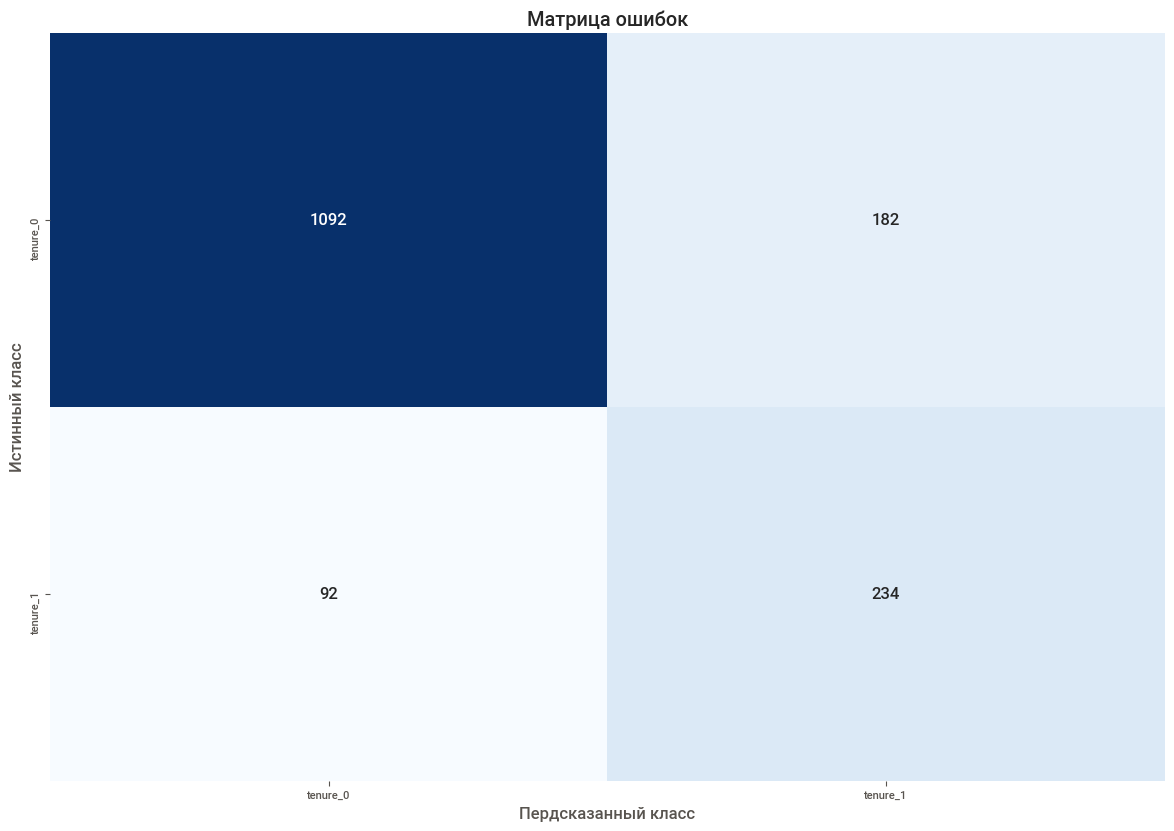

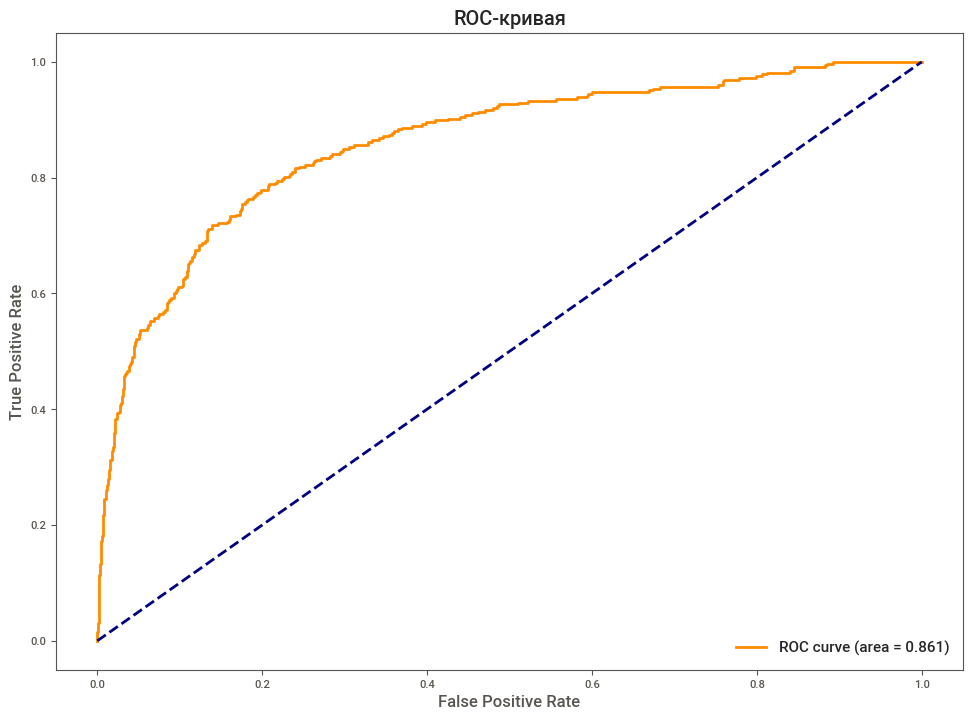

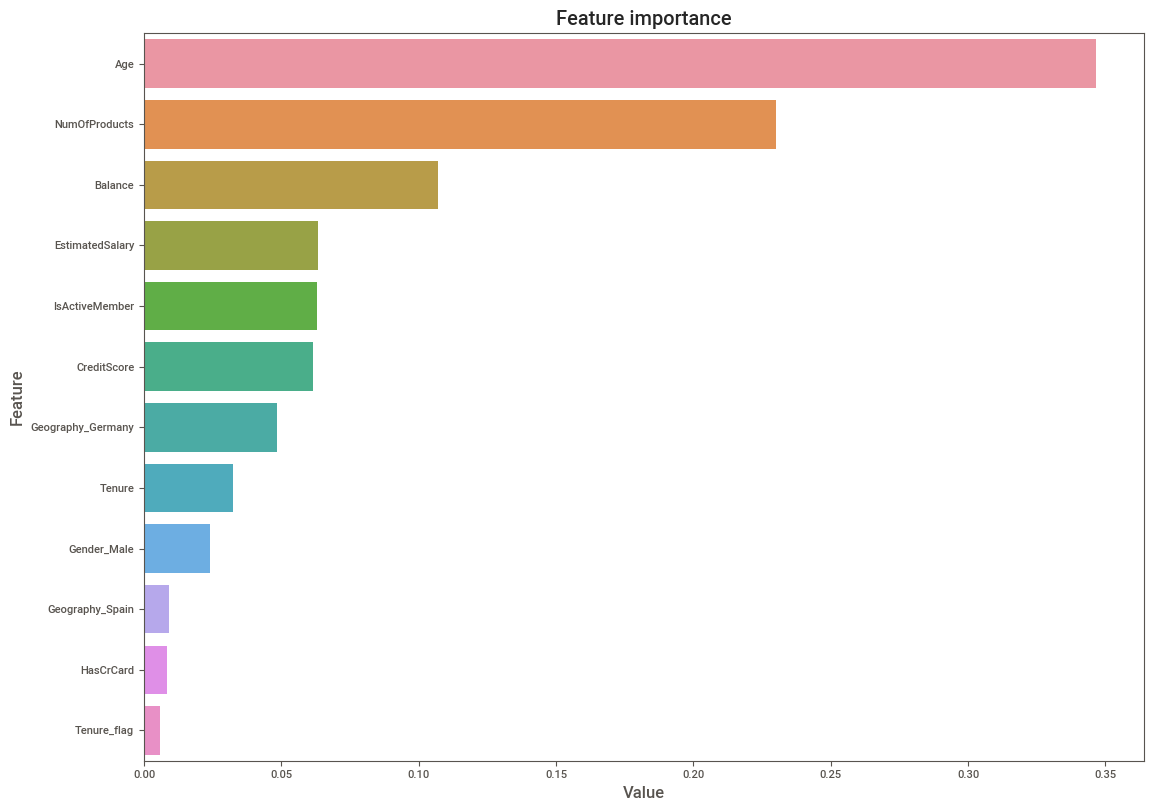

In [34]:
model_up = rs.best_estimator_.fit(features_train_upsampled, target_train_upsampled)
res_up = metric_info(features_valid, target_valid, model_up[0])

Применение методики upsampling позволило найти точку равновесия во всех трех метриках для положительного класса.
Для более наглядного сравнения сгруппируем метрики по трем экспериментам в одну таблицу

In [35]:
table = [res_disbalance, res_down, res_up]
df_table = pd.DataFrame(table, index=['model_disbalance', 'model_down', 'model_up'], columns=['roc_auc', 'precision', 'recall', 'f1'])
df_table

roc_auc  precision  recall     f1
model_disbalance    0.857      0.578   0.638  0.607
model_down          0.856      0.486   0.761  0.593
model_up            0.861      0.562   0.718  0.630

**Вывод**

Для устранения дисбаланса данных реализованы методики downsampling и upsampling. Более качественные результаты получены после применения upsampling. 

## Проверка модели на отложенных данных

Будем работать с обединенным набором данных "обучающий + валидационный". 

- применим к данным методику upsampling
- проверим: 
    - размеры выборок 
    - распределения одного из признаков до методики и после (на примере признака `CreditScore`)
    - распределение целевого класса

Размер выборок train_valid_upsampled: features (12890, 12), target (12890,)


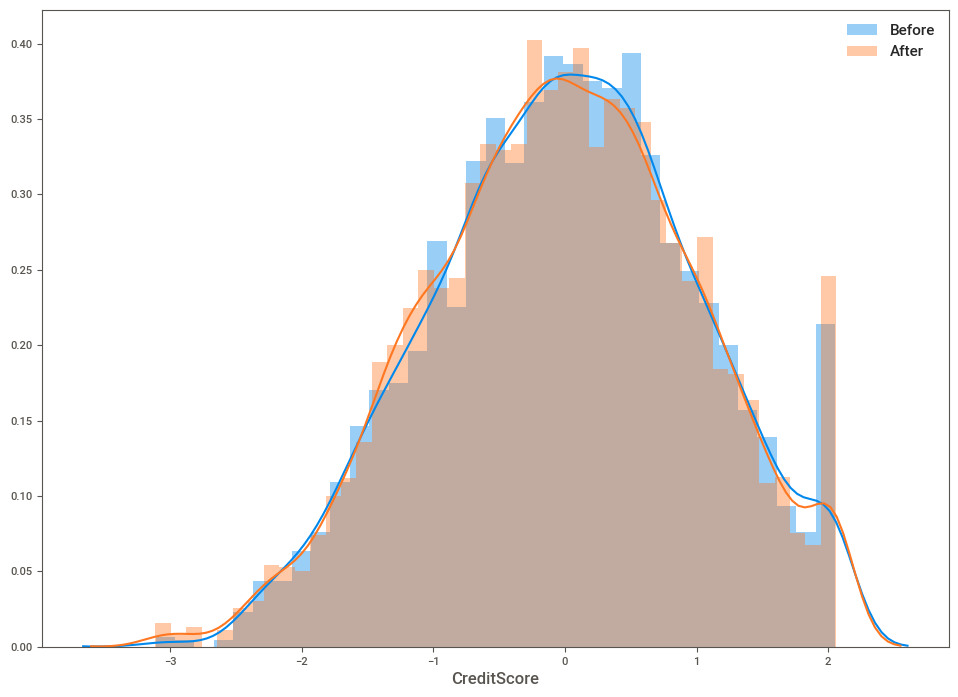

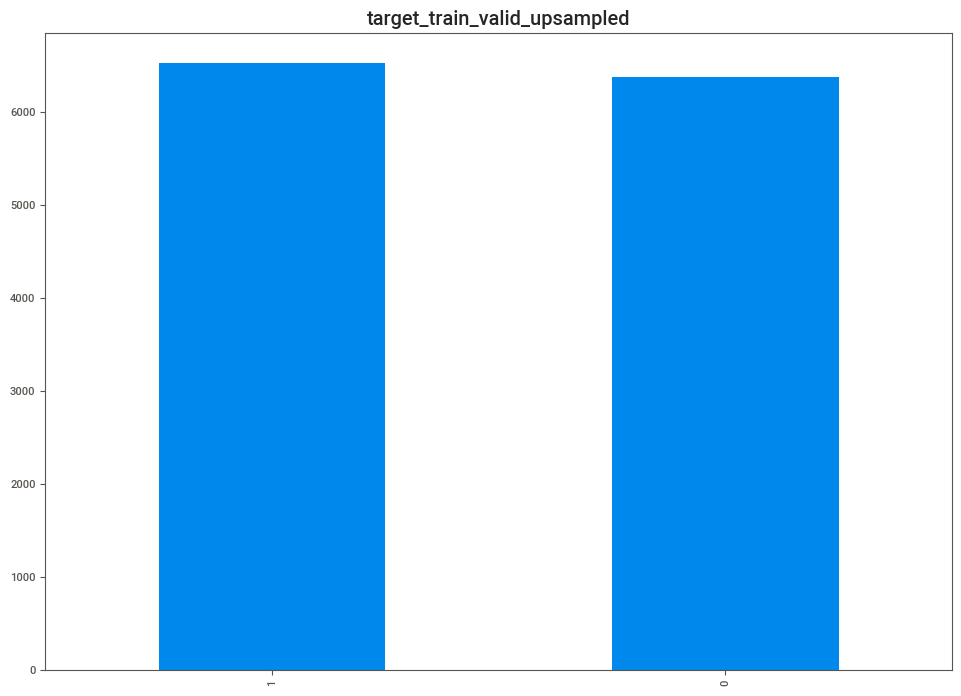

In [36]:
features_train_valid_upsampled, target_train_valid_upsampled = upsample(features_train_valid, target_train_valid, 4)

frame_shape({'train_valid_upsampled': [features_train_valid_upsampled, target_train_valid_upsampled]})

distribution_viz(features_train_valid_upsampled)

balance_viz(target_train_valid_upsampled, 'target_train_valid_upsampled')

ROC-AUC 0.866

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1593
           1       0.54      0.73      0.62       407

    accuracy                           0.82      2000
   macro avg       0.73      0.78      0.75      2000
weighted avg       0.85      0.82      0.83      2000



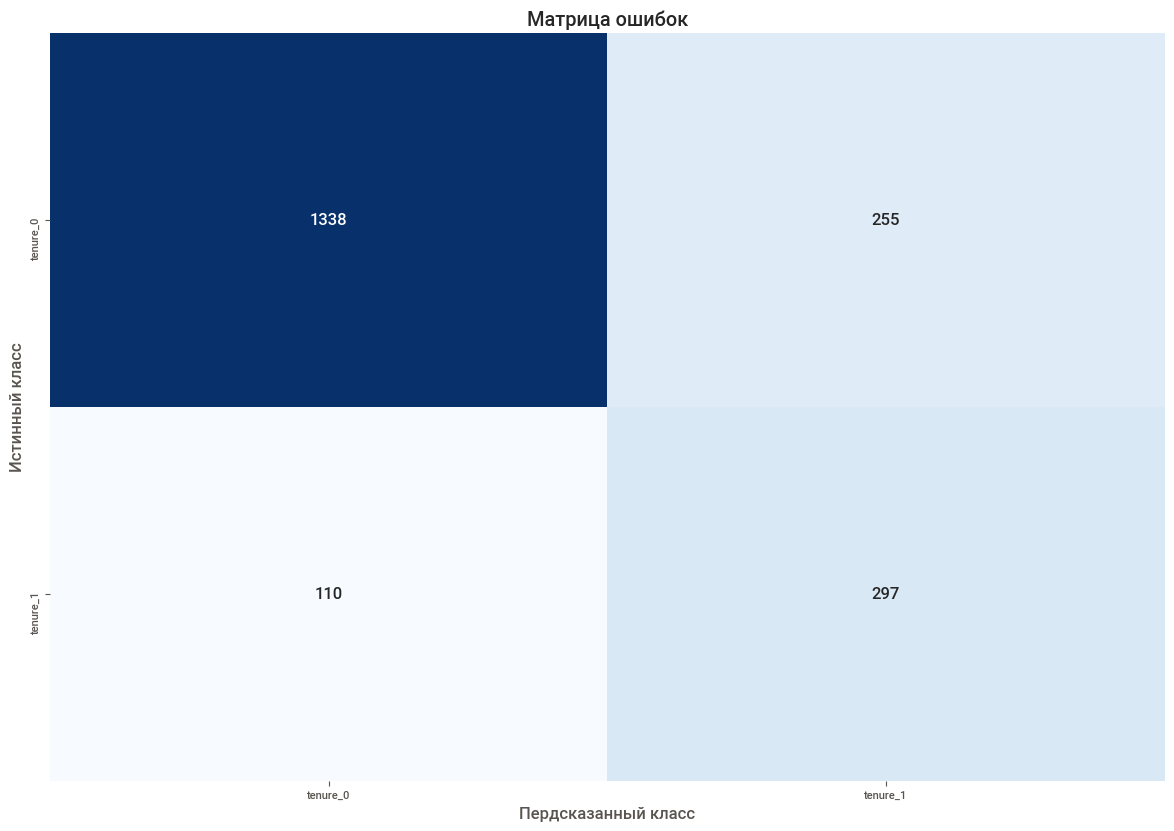

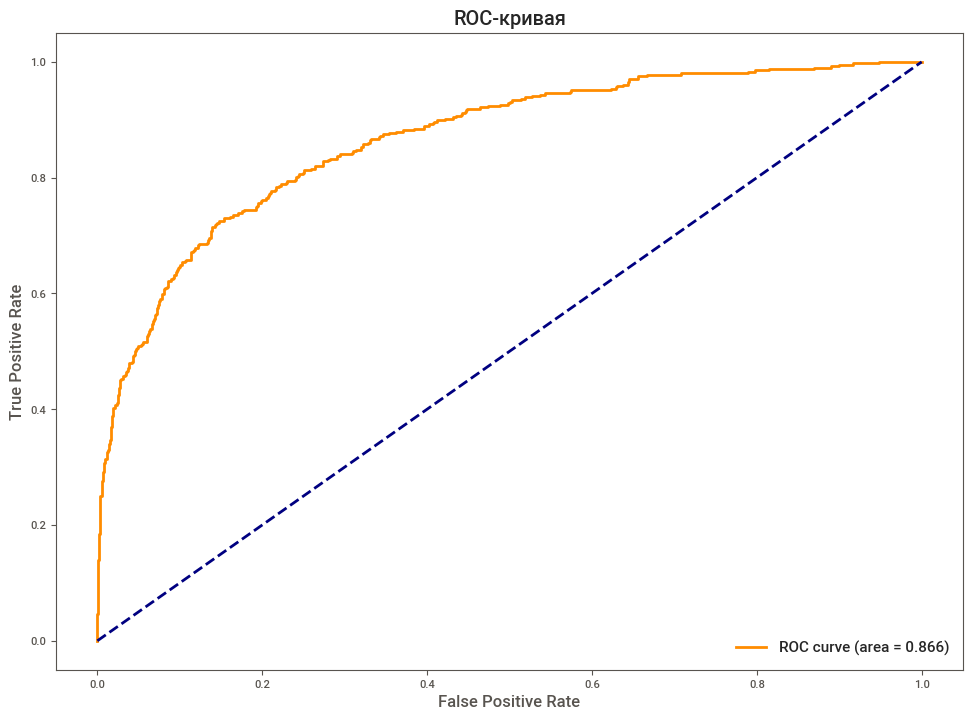

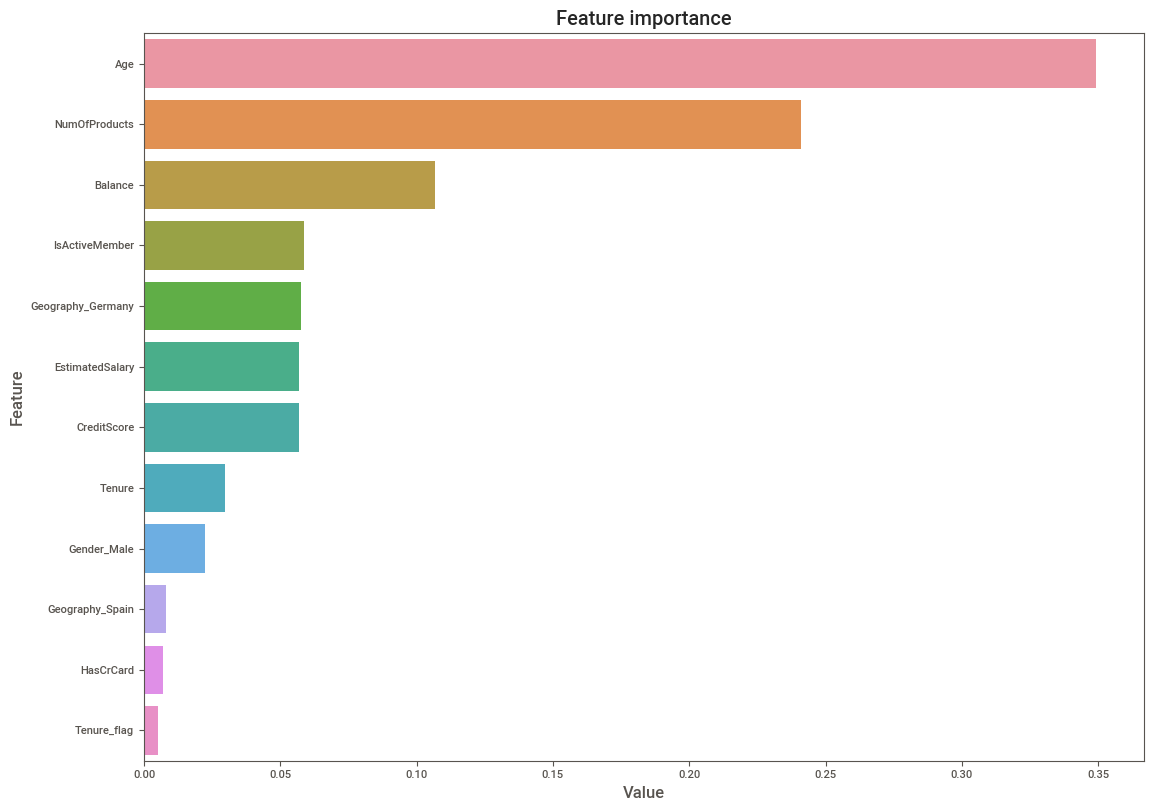

In [37]:
result_model_up = rs.best_estimator_.fit(features_train_valid_upsampled, target_train_valid_upsampled)
res = metric_info(features_test, target_test, result_model_up[0])

Т.к. после переобучения модели на объединенных данных повысилось количество ошибок I рода (отрицательные примеры, неверно классифицированные как положительные), есть смысл поиска оптимального порога классификации.

In [38]:
probabilities_valid = result_model_up.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1.1, 0.1):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_test, predicted_valid)
    recall = recall_score(target_test, predicted_valid)
    roc_auc = roc_auc_score(target_test, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, ROC-AUC = {:.3f}".format(
        threshold, precision, recall, roc_auc))

Порог = 0.00 | Точность = 0.203, Полнота = 1.000, ROC-AUC = 0.500
Порог = 0.10 | Точность = 0.221, Полнота = 0.993, ROC-AUC = 0.551
Порог = 0.20 | Точность = 0.269, Полнота = 0.978, ROC-AUC = 0.650
Порог = 0.30 | Точность = 0.347, Полнота = 0.904, ROC-AUC = 0.735
Порог = 0.40 | Точность = 0.437, Полнота = 0.821, ROC-AUC = 0.775
Порог = 0.50 | Точность = 0.538, Полнота = 0.730, ROC-AUC = 0.785
Порог = 0.60 | Точность = 0.659, Полнота = 0.600, ROC-AUC = 0.760
Порог = 0.70 | Точность = 0.774, Полнота = 0.462, ROC-AUC = 0.714
Порог = 0.80 | Точность = 0.873, Полнота = 0.322, ROC-AUC = 0.655
Порог = 0.90 | Точность = 0.960, Полнота = 0.118, ROC-AUC = 0.558
Порог = 1.00 | Точность = 0.000, Полнота = 0.000, ROC-AUC = 0.500


Наиболее оптимальным видится порог 0.6. Проверим как это повлияет на значения матрицы ошибок.

In [39]:
threshold = 0.6
result_thr = ((result_model_up.predict_proba(features_test)[:, 1]) > threshold).astype(int)

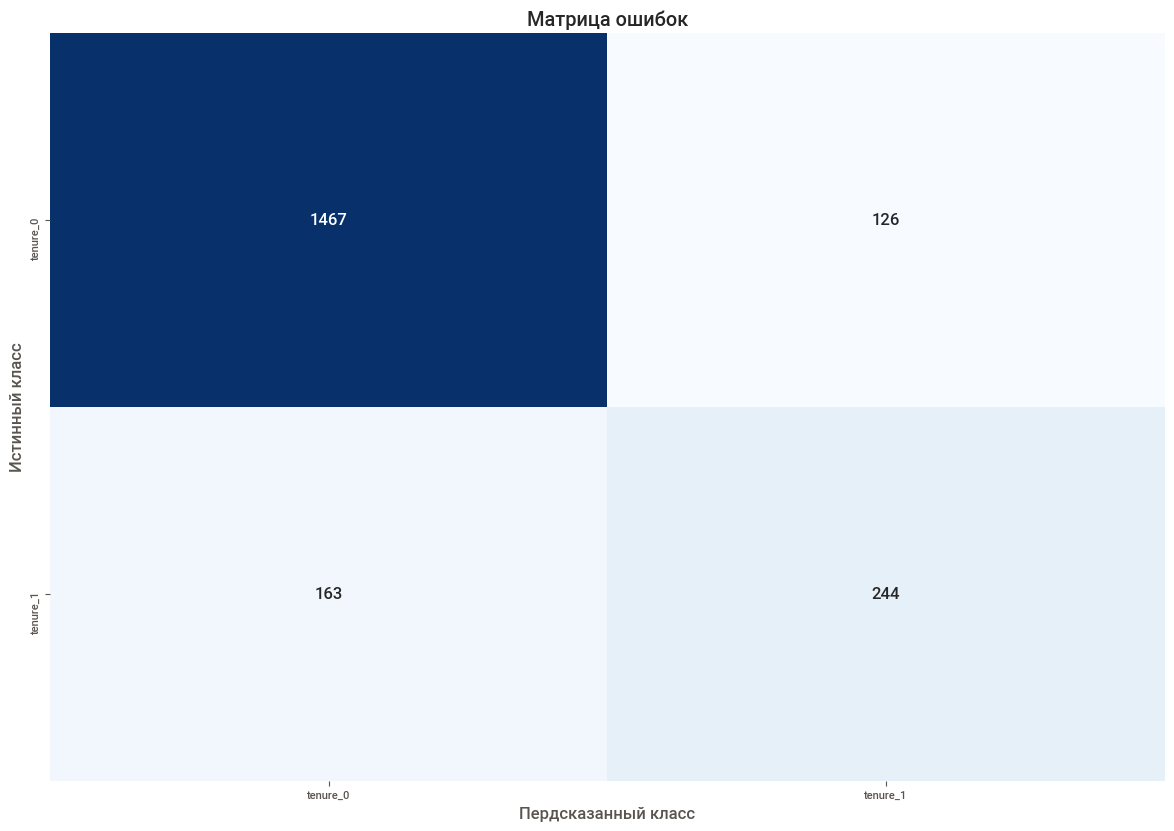

In [40]:
matrix = confusion_matrix(target_test, result_thr)
dataframe = pd.DataFrame(matrix, index=['tenure_0', 'tenure_1'], columns=['tenure_0', 'tenure_1'])
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues', fmt='.4g')
plt.title('Матрица ошибок');
plt.tight_layout();
plt.ylabel('Истинный класс');
plt.xlabel('Пердсказанный класс');
plt.show();

Мы вернулись к показателям, которые можно считать оптимальными для поставленной бизнес-задачи. 

**Вывод**

Произведена проверка объединенной модели (обучающая + валидационная выборки) на отложенной выборке (тестовые данные). Результаты показали хорошие показатели целевых метрик F1-score и ROC-AUC. При этом обнаружено ухудшение ситуации по ошибкам I рода (отрицательные примеры, неверно классифицированные как положительные) - их количество увеличилось. Для исправления ситуации была произведена операция подбора оптимального порога классификации. 

## Общий вывод

Проанализирован набор данных банк "Бета-Банк". Перед исследованием стояла задача построения классификационной модели по прогнозированию оттока клиентов (бинарная классификация).

В качестве метрики было обозначено F1-мера >= 0.59 на отложенной выборке. Дополнительно требовалось измерять AUC-ROC.

В процессе анализа были выявлены следующие особенности данных:
- 9.1% пропусков в признаке `Tenure` 
- дисбаланс по целевой переменной `Exited` 
- признаки с критичным значением уникальных значений: `Surname`, `CustomerId`, `RowNumber`

После предобработки набор данных был разбит на обучающую, валидационную и тестовую выборки. Были отмасштабированы признаки имеющие большой разброс значений. 

На обучающей выборке алгоритмы обучались выявлять зависимости в данных. В алгоритме по подбору гиперпараметров использовалась стратегия кросс-валидации, которая позволяет минимизировать проблему переобучения алгоритма. На отложенной тестовой выборке проверялась работа алгоритма, который, в сравнении с другими, показал лучшие результаты в процессе обучения.

В процессе моделирования были использованы следующие алгоритмы:

- LogisticRegression 
- DecisionTreeClassifier 
- RandomForestClassifier 
- CatBoostClassifier 
- GradientBoostingClassifier

Для алгоритмов задавались диапазоны гиперпараметров для нахождения их оптимальных значений.

Лучшие показатели продемонстрировала модель  RandomForestClassifier.

Т.к. изначально в данных была выявлена проблема дисбаланса, были опробированы методы его устранения: downsampling и upsampling. Метод upsampling продемонстрировал более качественные результаты. 

Победившая модель после применения методики upsampling продемонстрировала на отложенной выборке значение F1-меры равное 0.62, что больше чем требуемый baseline (0.59). 
Помимо F1-меры были проанализированы метрики: AUC-ROC, Precision, Recall. В результате анализа было выявлено, что метрика AUC-ROC может демонстрировать соразмерно одинаковые результаты, в то время как по метрикам Precision и Recall могут наблюдаться критичные проблемы в связи с наличием ошибок I и II рода. Обе можно считать критичными для поставленной бизнес задачи. В связи с этим для выбора оптимального классификатора был осуществлен подбор порога алгоитма для более качественного определения класса целевого признака.

Несмотря на хорошие показатели целевых метрик, есть задел для улучшения модели, т.к. результаты показали:

- наличие ложноотрицательных случаев - когда вместо прогнозирования ухода клиента, модель оворит, что он останется (это масимально критичный показатель для бизнес-задачи, т.к. банк может потерять клиентов не применив стратегий по их удерживанию)
- наличие ложноположительных случаев - когда прогнозируется, что клиент уйдет, а это не соответствет действительности (это тоже может быть критично для бизнеса, т.к. банк может расходовать лишние средства на попытки удержания лояльных клиентов)

Для получившейся модели наиболее важными оказались признаки "Возраст" и "Количество продуктов", "Баланс".